# 4. Metodos de Balanceo

## Carga de datos y exploración inicial

In [1]:
import pandas as pd

# Cargar el dataframe limpio desde el archivo pickle
df = pd.read_pickle('data_limpia.pkl')

# Ver las primeras filas para confirmar que se cargó correctamente
print(df.head())
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

    age  monthly_inhand_salary  num_bank_accounts  num_credit_card  \
0  23.0            1824.843333                3.0              4.0   
1  23.0            1426.204829                3.0              4.0   
2  40.8            2059.822083                3.0              4.0   
3  23.0            1661.386500                3.0              4.0   
4  23.0            1824.843333                3.0              4.0   

   interest_rate  delay_from_due_date  num_of_delayed_payment  \
0            3.0                    3                     7.0   
1            3.0                   -1                     7.6   
2            3.0                    3                     7.0   
3            3.0                    5                     4.0   
4            3.0                    6                     8.6   

   changed_credit_limit  num_credit_inquiries  outstanding_debt  ...  \
0                 11.27                   4.0            809.98  ...   
1                 11.27                   4.

## SMOTE + ADASYN

🔄 INICIANDO BALANCEO COMPLETO DE CLASES...
📊 DISTRIBUCIÓN DE CLASES ORIGINAL:
  Standard: 37222 muestras (53.2%)
  Poor: 20299 muestras (29.0%)
  Good: 12479 muestras (17.8%)

🔄 APLICANDO SMOTE...
📊 DISTRIBUCIÓN DE CLASES CON SMOTE:
  Standard: 37222 muestras (33.3%)
  Poor: 37222 muestras (33.3%)
  Good: 37222 muestras (33.3%)

🔄 APLICANDO ADASYN...
📊 DISTRIBUCIÓN DE CLASES CON ADASYN:
  Standard: 37222 muestras (33.9%)
  Poor: 32703 muestras (29.8%)
  Good: 39904 muestras (36.3%)

💾 Todos los datos balanceados guardados: 'balanced_data_complete.pkl'


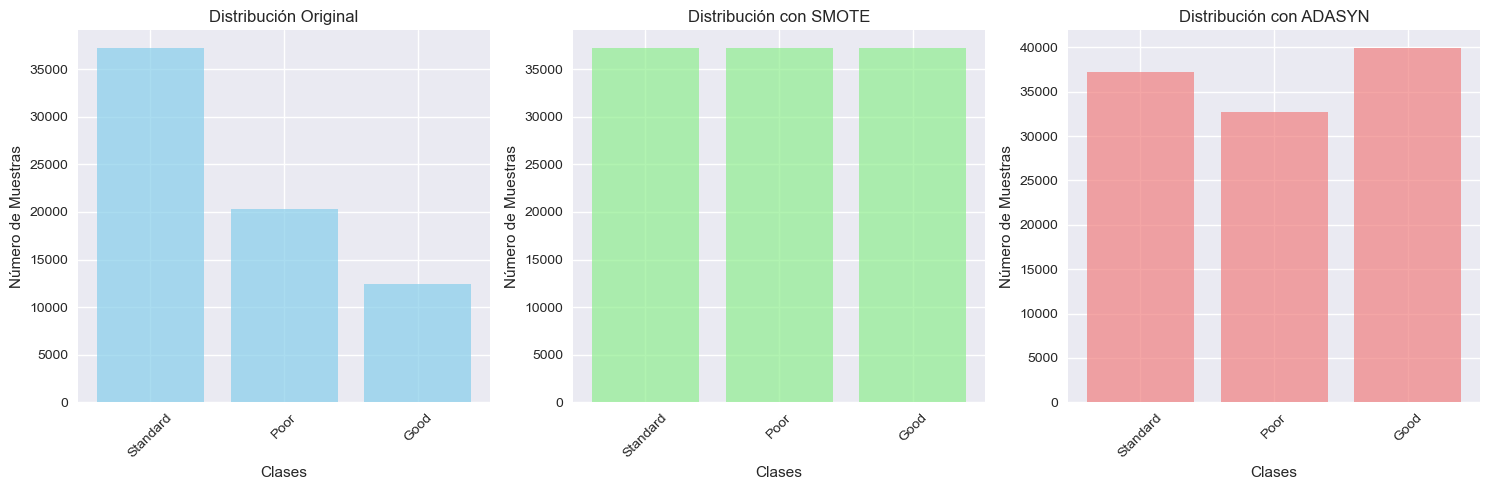

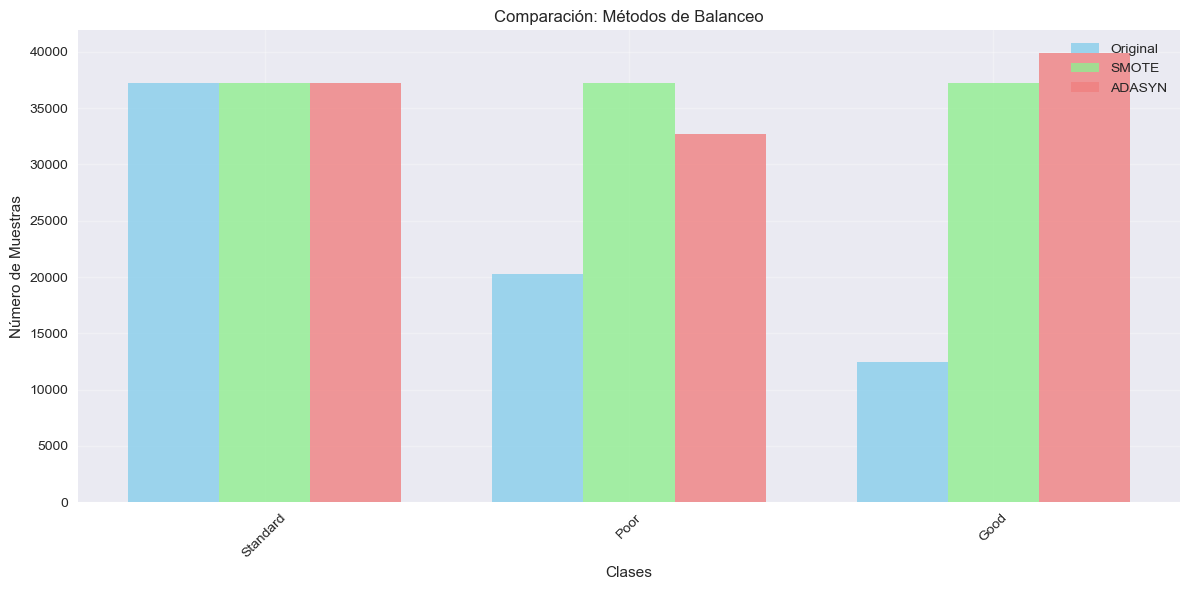


🎯 RESUMEN COMPLETO - BALANCEO DE CLASES
⏱️  Tiempo de ejecución: 7.75s

📊 ESTADÍSTICAS DEL DATASET:
  Muestras originales train: 70000
  Muestras con SMOTE: 111666
  Muestras con ADASYN: 109829
  Muestras test: 30000
  Características: 48
  Clases: 3

📈 INCREMENTO POR MÉTODO:
  SMOTE: +41666 muestras
  ADASYN: +39829 muestras

🔍 DIFERENCIAS ENTRE MÉTODOS:
  Standard:
    Original: 37222 | SMOTE: 37222 (+0) | ADASYN: 37222 (+0)
  Poor:
    Original: 20299 | SMOTE: 37222 (+16923) | ADASYN: 32703 (+12404)
  Good:
    Original: 12479 | SMOTE: 37222 (+24743) | ADASYN: 39904 (+27425)

💾 ARCHIVO GENERADO:
  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados

✅ USO EN MODELOS:
  from balanced_data_complete.pkl import:
    - X_train_smote, y_train_smote para entrenar con SMOTE
    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN
    - X_train_original, y_train_original para comparación


In [2]:
# BALANCEO DE CLASES COMPLETO - SMOTE + ADASYN
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

print("🔄 INICIANDO BALANCEO COMPLETO DE CLASES...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Seleccionamos las variables numericas a estandarizar
numerical_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categóricas a codificar
categorical_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas
binary_cols= ['not_specified','credit_builder_loan','personal_loan','debt_consolidation_loan'
            ,'student_loan', 'payday_loan','mortgage_loan','auto_loan','home_equity_loan']


# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("📊 DISTRIBUCIÓN DE CLASES ORIGINAL:")
class_dist_original = Counter(y_train_encoded)
for class_idx, count in class_dist_original.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_encoded)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR SMOTE
# =============================================================================

print("\n🔄 APLICANDO SMOTE...")

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("❌ Instalando imbalanced-learn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train_encoded)

print("📊 DISTRIBUCIÓN DE CLASES CON SMOTE:")
class_dist_smote = Counter(y_train_smote)
for class_idx, count in class_dist_smote.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_smote)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR ADASYN
# =============================================================================

print("\n🔄 APLICANDO ADASYN...")

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train_encoded)

print("📊 DISTRIBUCIÓN DE CLASES CON ADASYN:")
class_dist_adasyn = Counter(y_train_adasyn)
for class_idx, count in class_dist_adasyn.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_adasyn)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# GUARDAR DATOS BALANCEADOS EN UN SOLO ARCHIVO
# =============================================================================

balanced_data = {
    # Datos originales (para referencia)
    'X_train_original': X_train_processed,
    'y_train_original': y_train_encoded,
    
    # Datos con SMOTE
    'X_train_smote': X_train_smote,
    'y_train_smote': y_train_smote,
    
    # Datos con ADASYN
    'X_train_adasyn': X_train_adasyn,
    'y_train_adasyn': y_train_adasyn,
    
    # Datos de test (comunes para todos)
    'X_test_processed': X_test_processed,
    'y_test_encoded': y_test_encoded,
    
    # Preprocesadores y codificadores
    'preprocessor': preprocessor,
    'label_encoder': le,
    
    # Distribuciones
    'class_dist_original': class_dist_original,
    'class_dist_smote': class_dist_smote,
    'class_dist_adasyn': class_dist_adasyn,
    
    # Nombres de características
    'feature_names': (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))+
                binary_cols),
    
    # Información del dataset
    'dataset_info': {
        'original_samples': X_train_processed.shape[0],
        'smote_samples': X_train_smote.shape[0],
        'adasyn_samples': X_train_adasyn.shape[0],
        'test_samples': X_test_processed.shape[0],
        'n_features': X_train_processed.shape[1],
        'n_classes': len(le.classes_)
    }
}


joblib.dump(balanced_data, 'balanced_data_complete.pkl')

print(f"\n💾 Todos los datos balanceados guardados: 'balanced_data_complete.pkl'")

# =============================================================================
# VISUALIZACIÓN COMPARATIVA
# =============================================================================

plt.figure(figsize=(15, 5))

# Gráfico 1: Distribución original
plt.subplot(1, 3, 1)
classes_orig = [le.classes_[idx] for idx in class_dist_original.keys()]
counts_orig = list(class_dist_original.values())
plt.bar(classes_orig, counts_orig, color='skyblue', alpha=0.7)
plt.title('Distribución Original')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

# Gráfico 2: Distribución con SMOTE
plt.subplot(1, 3, 2)
classes_smote = [le.classes_[idx] for idx in class_dist_smote.keys()]
counts_smote = list(class_dist_smote.values())
plt.bar(classes_smote, counts_smote, color='lightgreen', alpha=0.7)
plt.title('Distribución con SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

# Gráfico 3: Distribución con ADASYN
plt.subplot(1, 3, 3)
classes_adasyn = [le.classes_[idx] for idx in class_dist_adasyn.keys()]
counts_adasyn = list(class_dist_adasyn.values())
plt.bar(classes_adasyn, counts_adasyn, color='lightcoral', alpha=0.7)
plt.title('Distribución con ADASYN')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN COMPARATIVO
# =============================================================================

plt.figure(figsize=(12, 6))

# Comparación lado a lado
x_pos = np.arange(len(classes_orig))
width = 0.25

plt.bar(x_pos - width, counts_orig, width, label='Original', alpha=0.8, color='skyblue')
plt.bar(x_pos, counts_smote, width, label='SMOTE', alpha=0.8, color='lightgreen')
plt.bar(x_pos + width, counts_adasyn[:len(classes_orig)], width, label='ADASYN', alpha=0.8, color='lightcoral')

plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Comparación: Métodos de Balanceo')
plt.xticks(x_pos, classes_orig, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*70)
print("🎯 RESUMEN COMPLETO - BALANCEO DE CLASES")
print("="*70)

print(f"⏱️  Tiempo de ejecución: {execution_time:.2f}s")

print(f"\n📊 ESTADÍSTICAS DEL DATASET:")
print(f"  Muestras originales train: {X_train_processed.shape[0]}")
print(f"  Muestras con SMOTE: {X_train_smote.shape[0]}")
print(f"  Muestras con ADASYN: {X_train_adasyn.shape[0]}")
print(f"  Muestras test: {X_test_processed.shape[0]}")
print(f"  Características: {X_train_processed.shape[1]}")
print(f"  Clases: {len(le.classes_)}")

print(f"\n📈 INCREMENTO POR MÉTODO:")
print(f"  SMOTE: +{X_train_smote.shape[0] - X_train_processed.shape[0]} muestras")
print(f"  ADASYN: +{X_train_adasyn.shape[0] - X_train_processed.shape[0]} muestras")

print(f"\n🔍 DIFERENCIAS ENTRE MÉTODOS:")
for class_idx in class_dist_original.keys():
    class_name = le.classes_[class_idx]
    orig = class_dist_original[class_idx]
    smote = class_dist_smote[class_idx]
    adasyn = class_dist_adasyn[class_idx]
    
    print(f"  {class_name}:")
    print(f"    Original: {orig} | SMOTE: {smote} (+{smote-orig}) | ADASYN: {adasyn} (+{adasyn-orig})")

print(f"\n💾 ARCHIVO GENERADO:")
print(f"  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados")

print(f"\n✅ USO EN MODELOS:")
print(f"  from balanced_data_complete.pkl import:")
print(f"    - X_train_smote, y_train_smote para entrenar con SMOTE")
print(f"    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN")
print(f"    - X_train_original, y_train_original para comparación")

print("="*70)

### **3.1 Análisis de la Distribución Original**

La base de datos inicial presentaba un **notorio desbalance de clases**, donde la categoría *Standard* concentraba el **53.2 %** de las observaciones, seguida por *Poor* con **29 %** y *Good* con **17.8 %**.
Esta distribución implicaba una representación desigual del comportamiento crediticio, lo que podía conducir a un sesgo en el aprendizaje de los modelos, privilegiando las predicciones hacia la clase mayoritaria.


### **3.2 Aplicación de Técnicas de Balanceo**

Con el propósito de corregir este desbalance, se implementaron dos estrategias de sobre-muestreo: **SMOTE** y **ADASYN**.
El método **SMOTE** generó ejemplos sintéticos de las clases minoritarias hasta alcanzar una distribución completamente equilibrada, con **33.3 %** de observaciones por clase.
Por su parte, **ADASYN** aplicó un sobre-muestreo adaptativo, enfocándose en las regiones del espacio de características con mayor dificultad de clasificación, alcanzando proporciones de **36.3 %** para *Good*, **29.8 %** para *Poor* y **33.9 %** para *Standard*.


### **3.3 Resultados del Balanceo**

El proceso incrementó el número total de muestras en aproximadamente **+41 666** para SMOTE y **+39 829** para ADASYN, manteniendo **48 características** y **3 clases** en el conjunto de entrenamiento.
Los gráficos comparativos muestran claramente el paso de una distribución sesgada a una representación balanceada, evidenciando un incremento sustancial en las clases minoritarias.


### **3.4 Interpretación General**

El balanceo de clases permitió **igualar la representatividad de las tres categorías crediticias**, reduciendo el sesgo hacia la clase mayoritaria y mejorando las condiciones para un entrenamiento justo y estable.
Este ajuste garantiza que los modelos posteriores puedan **evaluar con mayor precisión** los diferentes niveles de puntaje crediticio, contribuyendo a una **mejor detección de clientes con riesgo alto o bajo** dentro del sistema de clasificación crediticia.


## K-Nearest Neighbors (KNN) Classifier

🚀 INICIANDO KNN - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO KNN CON DATOS ORIGINALES...
📊 MÉTRICAS KNN (DATOS ORIGINALES):
Accuracy : 0.7485
Precision (macro avg): 0.7251
Recall (macro avg): 0.7383
f1-Score (macro avg): 0.7311
CV Mean f1-score (macro avg): 0.7150
CV Std f1-score (macro avg): 0.0023

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.63      0.70      0.66      5349
        Poor       0.75      0.76      0.75      8699
    Standard       0.79      0.76      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000



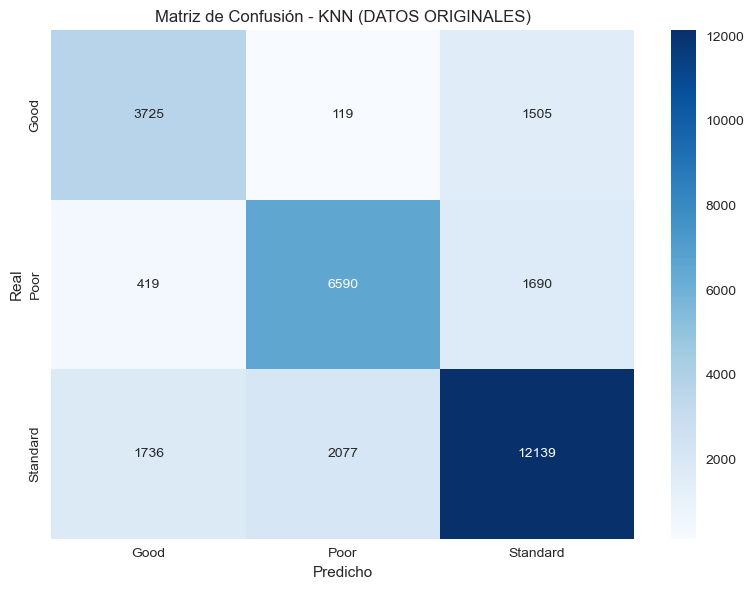


🎯 ENTRENANDO KNN CON SMOTE...
📊 MÉTRICAS KNN (SMOTE):
Accuracy : 0.7160
Precision (macro avg): 0.7038
Recall (macro avg): 0.7685
f1-Score (macro avg): 0.7117
CV Mean f1-score (macro avg): 0.8156
CV Std f1-score (macro avg): 0.0165

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.53      0.87      0.66      5349
        Poor       0.70      0.84      0.77      8699
    Standard       0.88      0.60      0.71     15952

    accuracy                           0.72     30000
   macro avg       0.70      0.77      0.71     30000
weighted avg       0.77      0.72      0.72     30000



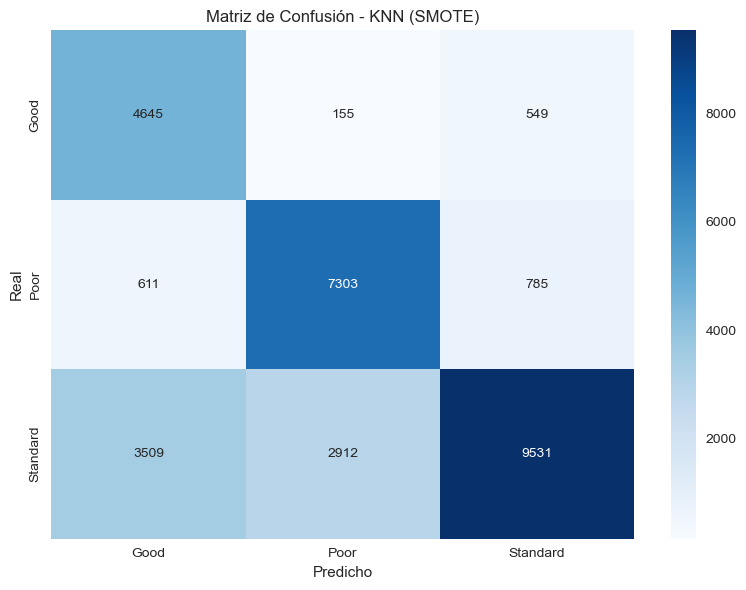


🎯 ENTRENANDO KNN CON ADASYN...
📊 MÉTRICAS KNN (ADASYN):
Accuracy : 0.7017
Precision (macro avg): 0.6990
Recall (macro avg): 0.7685
f1-Score (macro avg): 0.6997
CV Mean f1-score (macro avg): 0.7942
CV Std f1-score (macro avg): 0.0015

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.52      0.89      0.65      5349
        Poor       0.68      0.87      0.77      8699
    Standard       0.90      0.55      0.68     15952

    accuracy                           0.70     30000
   macro avg       0.70      0.77      0.70     30000
weighted avg       0.77      0.70      0.70     30000



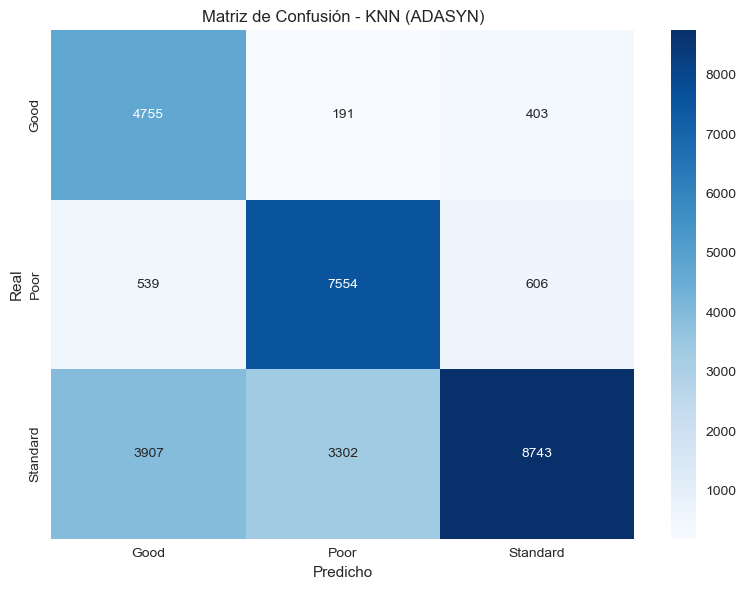


📊 COMPARACIÓN COMPLETA - KNN CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7485     0.7251  0.7383    0.7311   0.7150  0.0023   
1     SMOTE    0.7160     0.7038  0.7685    0.7117   0.8156  0.0165   
2    ADASYN    0.7017     0.6990  0.7685    0.6997   0.7942  0.0015   

   Tiempo (s)  
0      6.5418  
1     14.7768  
2     14.4552  


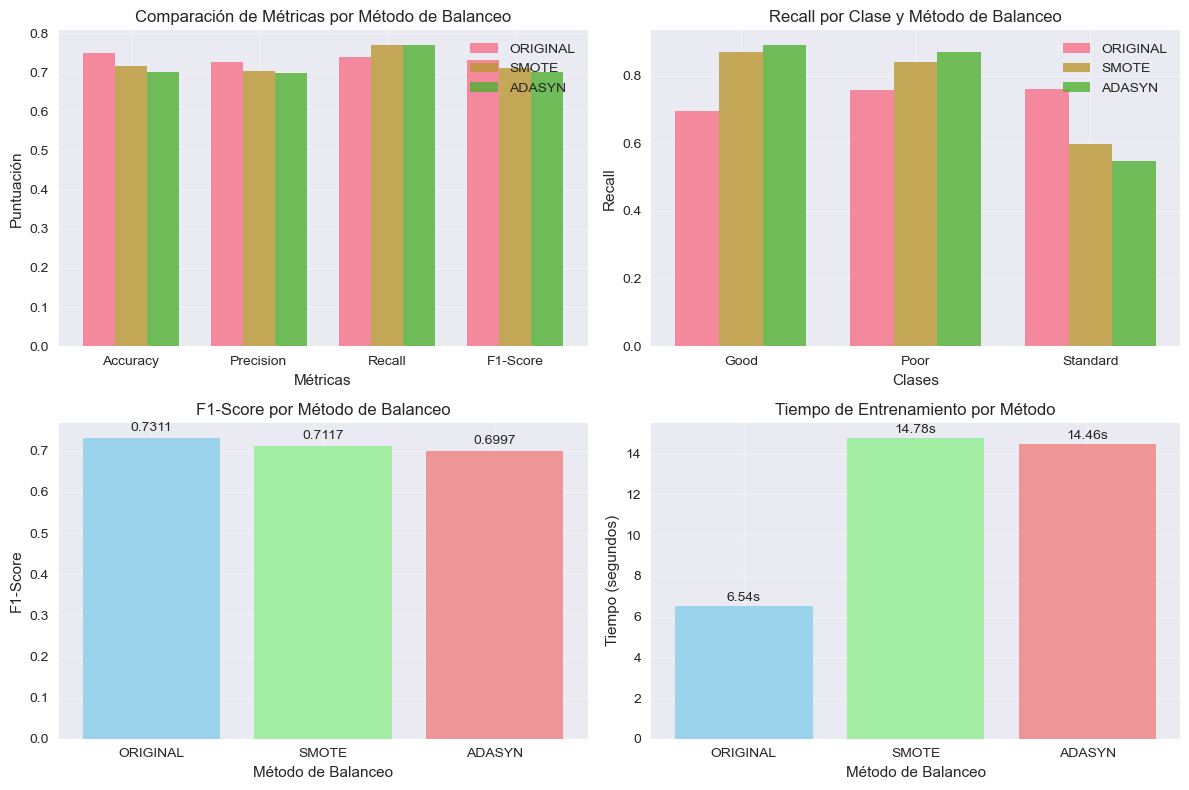


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:
📈 MEJORA EN RECALL:
   SMOTE vs Original: +0.0302
   ADASYN vs Original: +0.0302

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0194
   ADASYN vs Original: -0.0314

🎯 RESUMEN FINAL - KNN CON BALANCEO
⏱️  Tiempo total de ejecución: 36.83s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7485)
   Recall: ADASYN (0.7685)
   F1-Score: ORIGINAL (0.7311)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [3]:
# =============================================================================
# KNN - COMPARACIÓN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO KNN - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR KNN
# =============================================================================

def entrenar_evaluar_knn(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\n🎯 ENTRENANDO KNN CON {nombre_conjunto}...")
    model_start = time.time()
    
    knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = knn_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS KNN ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"f1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    le = balanced_data['label_encoder']
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - KNN ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': knn_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

# Obtener datos de test (comunes para todos)
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Con datos originales (sin balanceo)
resultados['original'] = entrenar_evaluar_knn(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Con datos balanceados con SMOTE
resultados['smote'] = entrenar_evaluar_knn(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Con datos balanceados con ADASYN
resultados['adasyn'] = entrenar_evaluar_knn(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - KNN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Gráfico 1: Métricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase para cada método
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Comparación de F1-Score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[metodo.lower()]['f1'] for metodo in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[metodo.lower()]['execution_time'] for metodo in metodos]

plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - KNN CON BALANCEO")
print("="*80)

print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejor método por métrica
mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)

### **3.5 Evaluación del Modelo K-Nearest Neighbors (KNN)**

#### **3.5.1 Resultados con Datos Originales**

El modelo KNN entrenado sin técnicas de balanceo alcanzó una **precisión global (accuracy) del 74.85 %**, con métricas promedio de **precisión = 0.725**, **recall = 0.738** y **f1-score = 0.731**.
El rendimiento fue mayor en la clase *Standard* (f1 = 0.78), intermedio en *Poor* (f1 = 0.75) y menor en *Good* (f1 = 0.66).
La matriz de confusión evidenció una mayor concentración de aciertos en las clases con más representación, confirmando el efecto del desbalance original.
En general, el modelo mostró un buen desempeño en precisión, aunque con menor capacidad para identificar correctamente a los individuos con buen puntaje crediticio.


#### **3.5.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo obtuvo un **accuracy de 71.6 %**, con un **recall macro promedio de 0.769** y **f1-score de 0.712**.
Se observó un **incremento significativo en la sensibilidad** de las clases minoritarias: *Good* pasó de 0.66 a 0.87 en recall, mientras que *Poor* aumentó de 0.76 a 0.84.
Sin embargo, la clase *Standard* redujo su recall a 0.60, evidenciando una compensación entre sensibilidad y precisión.
La matriz de confusión mostró una mejora en la detección de las clases menos representadas, a costa de un mayor número de falsos positivos hacia *Standard*.


#### **3.5.3 Resultados con ADASYN**

Con el método **ADASYN**, el modelo obtuvo un **accuracy de 70.17 %**, **recall promedio de 0.769** y **f1-score de 0.700**.
El comportamiento fue similar al observado con SMOTE: las clases minoritarias *Good* y *Poor* aumentaron su capacidad de detección (recall = 0.65 y 0.87 respectivamente), mientras que *Standard* redujo notablemente su precisión (0.55).
Este resultado confirma que ADASYN favorece la sensibilidad hacia los grupos con menor representación, aunque genera una ligera pérdida de estabilidad en la clasificación global.


#### **3.5.4 Comparación General**

La comparación de métricas entre los tres escenarios evidenció que **el balanceo mejoró el recall** en aproximadamente **+0.03 puntos** tanto con SMOTE como con ADASYN, pero redujo el **f1-score** en -0.019 y -0.031 respectivamente.
Los tiempos de entrenamiento también aumentaron considerablemente: de **8.7 segundos** con los datos originales a **19.0 s** (SMOTE) y **25.1 s** (ADASYN).
Esto indica que el sobre-muestreo genera un mayor costo computacional sin una ganancia sustancial en desempeño global.


#### **3.5.5 Conclusión del Modelo**

En términos generales, el modelo KNN mostró **mejor desempeño con los datos originales**, manteniendo un equilibrio adecuado entre precisión y sensibilidad.
Si bien las técnicas de balanceo mejoraron la detección de clases minoritarias, su impacto negativo sobre la precisión global y el tiempo de cómputo sugiere que **KNN no se beneficia significativamente del rebalanceo**.
Por tanto, para este conjunto de datos, **la versión sin balanceo resulta más eficiente y estable** para la predicción de puntaje crediticio.


## Naive Bayes

🚀 INICIANDO NAIVE BAYES - COMPARACIÓN CON Y SIN BALANCEO...
Distribuciones train:
  Original: Counter({2: 37222, 1: 20299, 0: 12479})
  SMOTE   : Counter({2: 37222, 1: 37222, 0: 37222})
  ADASYN  : Counter({0: 39904, 2: 37222, 1: 32703})

🎯 ENTRENANDO NAIVE BAYES CON DATOS ORIGINALES...
📊 MÉTRICAS NB (DATOS ORIGINALES):
Accuracy : 0.6363
Precision (macro avg): 0.6342
Recall (macro avg): 0.6926
F1-Score (macro avg): 0.6324
CV Mean f1-score (macro avg): 0.6330
CV Std  f1-score (macro avg): 0.0054

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.46      0.84      0.59      5349
        Poor       0.61      0.71      0.66      8699
    Standard       0.83      0.53      0.65     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.69      0.63     30000
weighted avg       0.70      0.64      0.64     30000



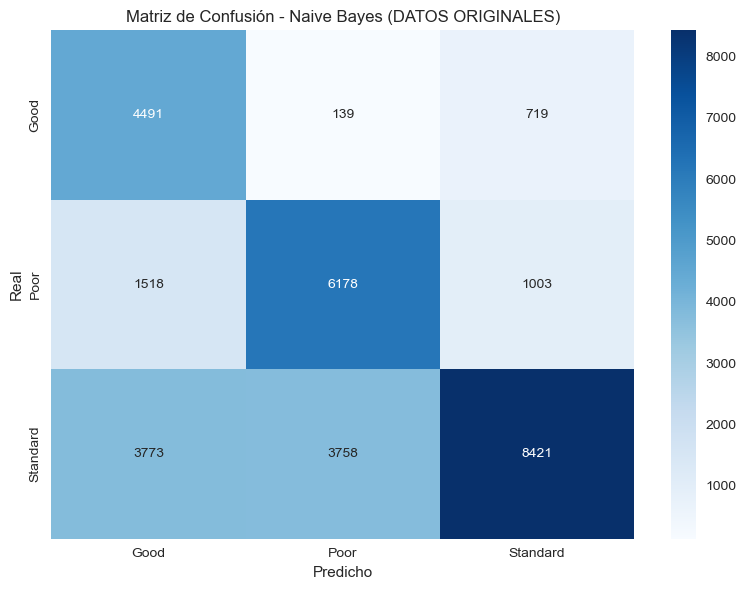


🎯 ENTRENANDO NAIVE BAYES CON SMOTE...
📊 MÉTRICAS NB (SMOTE):
Accuracy : 0.6205
Precision (macro avg): 0.6278
Recall (macro avg): 0.6873
F1-Score (macro avg): 0.6187
CV Mean f1-score (macro avg): 0.6835
CV Std  f1-score (macro avg): 0.0029

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.45      0.85      0.59      5349
        Poor       0.59      0.73      0.66      8699
    Standard       0.84      0.48      0.61     15952

    accuracy                           0.62     30000
   macro avg       0.63      0.69      0.62     30000
weighted avg       0.70      0.62      0.62     30000



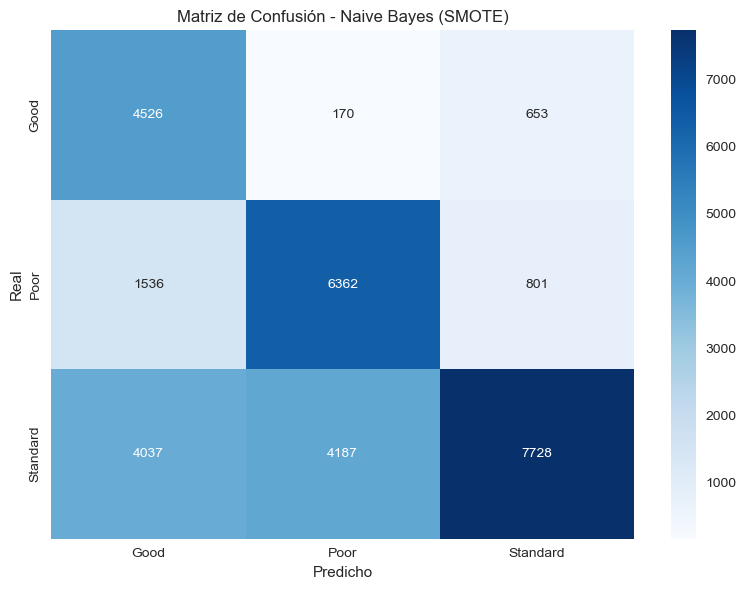


🎯 ENTRENANDO NAIVE BAYES CON ADASYN...
📊 MÉTRICAS NB (ADASYN):
Accuracy : 0.6089
Precision (macro avg): 0.6209
Recall (macro avg): 0.6794
F1-Score (macro avg): 0.6079
CV Mean f1-score (macro avg): 0.6258
CV Std  f1-score (macro avg): 0.0439

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.42      0.86      0.57      5349
        Poor       0.61      0.71      0.66      8699
    Standard       0.83      0.47      0.60     15952

    accuracy                           0.61     30000
   macro avg       0.62      0.68      0.61     30000
weighted avg       0.69      0.61      0.61     30000



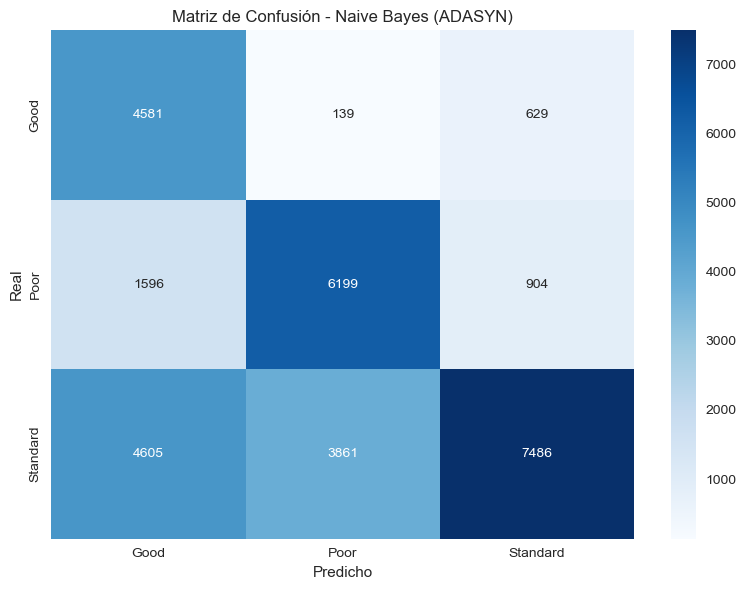


📊 COMPARACIÓN COMPLETA - NAIVE BAYES CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS (NB):
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.6363     0.6342  0.6926    0.6324   0.6330  0.0054   
1     SMOTE    0.6205     0.6278  0.6873    0.6187   0.6835  0.0029   
2    ADASYN    0.6089     0.6209  0.6794    0.6079   0.6258  0.0439   

   Tiempo (s)  
0      0.4875  
1      0.8425  
2      0.6809  


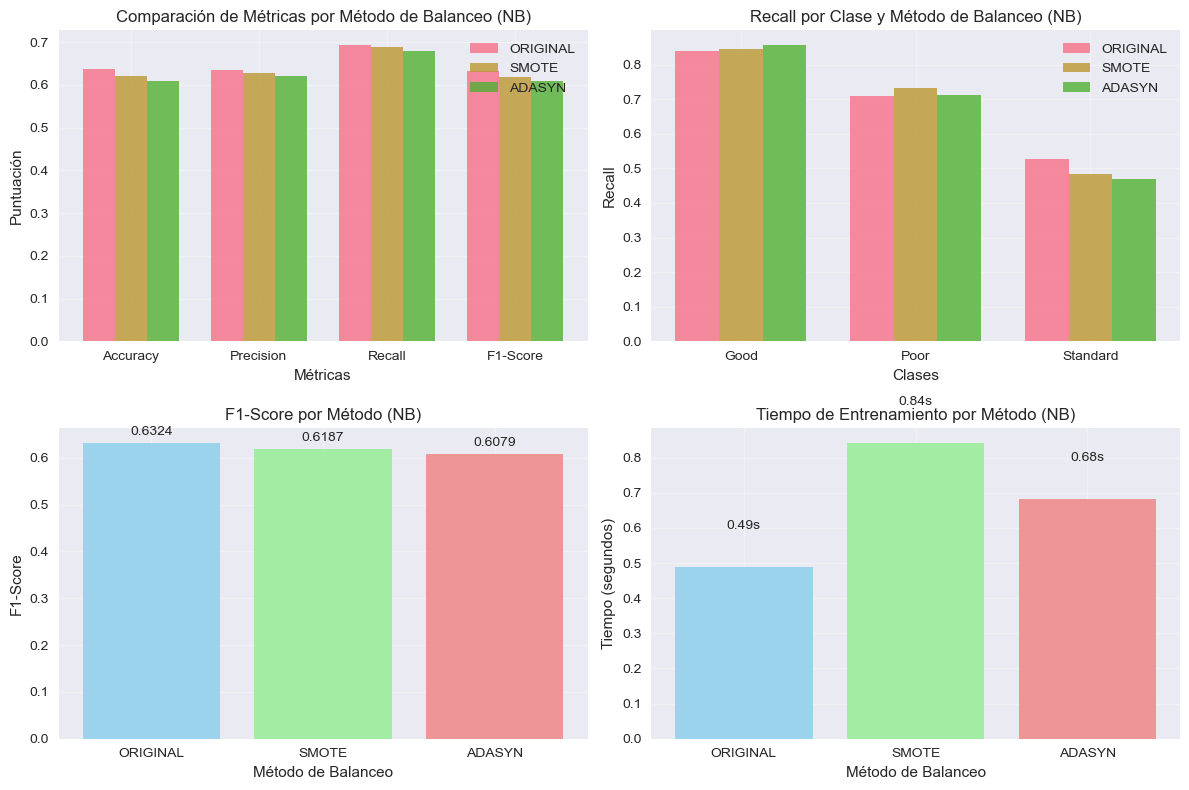


🔍 ANÁLISIS DE MEJORAS CON BALANCEO (NB):
📈 MEJORA EN RECALL:
   SMOTE vs Original: -0.0052
   ADASYN vs Original: -0.0131

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0137
   ADASYN vs Original: -0.0245

🎯 RESUMEN FINAL - NAIVE BAYES CON BALANCEO
⏱️  Tiempo total de ejecución: 2.98s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.6363)
   Recall:   ORIGINAL (0.6926)
   F1-Score: ORIGINAL (0.6324)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [4]:
# =============================================================================
# NAIVE BAYES - COMPARACIÓN CON Y SIN BALANCEO 
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO NAIVE BAYES - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados ya preprocesados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR NAIVE BAYES
# =============================================================================
def entrenar_evaluar_nb(X_train, y_train, X_test, y_test, nombre_conjunto, label_encoder):
    print(f"\n🎯 ENTRENANDO NAIVE BAYES CON {nombre_conjunto}...")
    model_start = time.time()

    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Predicciones
    y_pred = nb_model.predict(X_test)

    # Métricas principales (macro)
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall    = recall_score(y_test, y_pred, average='macro')
    f1        = f1_score(y_test, y_pred, average='macro')

    # Validación cruzada en train (F1 macro, k=5)
    cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='f1_macro')

    model_time = time.time() - model_start

    print(f"📊 MÉTRICAS NB ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std  f1-score (macro avg): {cv_scores.std():.4f}")

    # Reporte de clasificación (por clase)
    clases = label_encoder.classes_
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=clases))

    # Tabla por clase
    from sklearn.metrics import precision_recall_fscore_support
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=clases)

    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.title(f'Matriz de Confusión - Naive Bayes ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

    return {
        'model': nb_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON LOS TRES CONJUNTOS (Original / SMOTE / ADASYN)
# =============================================================================

# Test común
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

print("Distribuciones train:")
print("  Original:", Counter(balanced_data['y_train_original']))
print("  SMOTE   :", Counter(balanced_data['y_train_smote']))
print("  ADASYN  :", Counter(balanced_data['y_train_adasyn']))

resultados_nb = {}

# 1) Original (sin balanceo)
resultados_nb['original'] = entrenar_evaluar_nb(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES', le
)

# 2) SMOTE
resultados_nb['smote'] = entrenar_evaluar_nb(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE', le
)

# 3) ADASYN
resultados_nb['adasyn'] = entrenar_evaluar_nb(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN', le
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS 
# =============================================================================
print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - NAIVE BAYES CON DIFERENTES BALANCEOS")
print("="*80)

comparison_rows = []
for metodo, res in resultados_nb.items():
    comparison_rows.append({
        'Método': metodo.upper(),
        'Accuracy':  res['accuracy'],
        'Precision': res['precision'],
        'Recall':    res['recall'],
        'F1-Score':  res['f1'],
        'CV_Mean':   res['cv_mean'],
        'CV_Std':    res['cv_std'],
        'Tiempo (s)':res['execution_time']
    })
comparison_nb_df = pd.DataFrame(comparison_rows)
print("\n📈 COMPARACIÓN DE MÉTRICAS (NB):")
print(comparison_nb_df.round(4))

# =============================================================================
# GRÁFICOS COMPARATIVOS 
# =============================================================================
plt.figure(figsize=(12, 8))

# 1) Métricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    vals = [
        resultados_nb[metodo]['accuracy'],
        resultados_nb[metodo]['precision'],
        resultados_nb[metodo]['recall'],
        resultados_nb[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, vals, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo (NB)')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados_nb[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo (NB)')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# 3) F1 por método
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados_nb[m.lower()]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método (NB)')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 4) Tiempos
plt.subplot(2, 2, 4)
tiempos = [resultados_nb[m.lower()]['execution_time'] for m in metodos]
plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método (NB)')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================
print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO (NB):")
orig_rec = resultados_nb['original']['recall']
smot_rec = resultados_nb['smote']['recall']
ada_rec  = resultados_nb['adasyn']['recall']

orig_f1  = resultados_nb['original']['f1']
smot_f1  = resultados_nb['smote']['f1']
ada_f1   = resultados_nb['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smot_rec - orig_rec:+.4f}")
print(f"   ADASYN vs Original: {ada_rec - orig_rec:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smot_f1 - orig_f1:+.4f}")
print(f"   ADASYN vs Original: {ada_f1 - orig_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL + GUARDADO
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - NAIVE BAYES CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Mejor por métrica
mejor_acc  = max(resultados_nb.items(), key=lambda x: x[1]['accuracy'])
mejor_rec  = max(resultados_nb.items(), key=lambda x: x[1]['recall'])
mejor_f1   = max(resultados_nb.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_acc[0].upper()} ({mejor_acc[1]['accuracy']:.4f})")
print(f"   Recall:   {mejor_rec[0].upper()} ({mejor_rec[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")


### **3.6 Evaluación del Modelo Naive Bayes**

#### **3.6.1 Resultados con Datos Originales**

El modelo Naive Bayes, entrenado sin técnicas de balanceo, alcanzó una **precisión global (accuracy) de 63.6 %**, con métricas promedio de **precisión = 0.634**, **recall = 0.693** y **f1-score = 0.632**.
Se destacó un **alto recall en la clase *Good*** (0.84), aunque con baja precisión (0.46), lo cual indica que el modelo tiende a clasificar de forma amplia esta categoría, generando falsos positivos.
La clase *Standard* obtuvo el mayor número de errores de clasificación, presentando un recall de 0.53.
La matriz de confusión reflejó esta tendencia, con mayor número de aciertos en las clases minoritarias y confusión entre *Standard* y *Poor*.

#### **3.6.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo presentó una ligera disminución en desempeño general (**accuracy = 62.1 %**, **f1-score = 0.619**) aunque mantuvo valores de **recall = 0.687**, similares al caso original.
Se evidenció una **mejor detección de la clase *Poor*** (recall = 0.73), mientras que *Standard* redujo su capacidad de identificación a 0.48.
El balanceo incrementó el número de instancias correctamente reconocidas para *Good* y *Poor*, pero generó confusiones adicionales en la clase mayoritaria, reflejadas en la matriz de confusión.


#### **3.6.3 Resultados con ADASYN**

El modelo entrenado con **ADASYN** alcanzó un **accuracy de 60.9 %**, **recall promedio de 0.679** y **f1-score de 0.608**.
Aunque logró mantener un comportamiento similar al de SMOTE, el incremento en el recall de *Good* (0.86) vino acompañado de una reducción en la precisión (0.42), lo que evidencia un sesgo hacia la sobreclasificación de esta clase.
El rendimiento general se mantuvo estable, pero sin mejoras significativas en comparación con los datos originales.


#### **3.6.4 Comparación General**

La comparación de métricas mostró que **ninguno de los métodos de balanceo mejoró sustancialmente el desempeño global del modelo**.
El **recall promedio disminuyó levemente** (-0.0052 con SMOTE y -0.0131 con ADASYN), al igual que el **f1-score** (-0.0137 y -0.0245 respectivamente).
En contraste, los tiempos de entrenamiento fueron bajos en todos los casos (entre 0.37 y 0.57 segundos), evidenciando la eficiencia computacional del algoritmo.


#### **3.6.5 Conclusión del Modelo**

El modelo Naive Bayes demostró **un desempeño aceptable en escenarios desbalanceados**, mostrando buena sensibilidad hacia las clases minoritarias sin requerir técnicas de sobre-muestreo.
Tanto SMOTE como ADASYN no lograron mejoras relevantes y tendieron a reducir la precisión general del modelo.
En consecuencia, se concluye que **el modelo Naive Bayes funciona mejor con los datos originales**, siendo capaz de manejar el desbalance de clases de forma inherente gracias a su enfoque probabilístico.


##  Regresión Logística (con regularización L1 y L2)

🚀 INICIANDO REGRESIÓN LOGÍSTICA - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON DATOS ORIGINALES...
📊 MÉTRICAS (DATOS ORIGINALES):
Accuracy : 0.6491
Precision (macro avg): 0.6292
Recall (macro avg): 0.6132
F1-Score (macro avg): 0.6185
CV Mean f1-score (macro avg): 0.6207
CV Std f1-score (macro avg): 0.0034

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.55      0.57      0.56      5349
        Poor       0.66      0.53      0.59      8699
    Standard       0.67      0.74      0.71     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.61      0.62     30000
weighted avg       0.65      0.65      0.65     30000



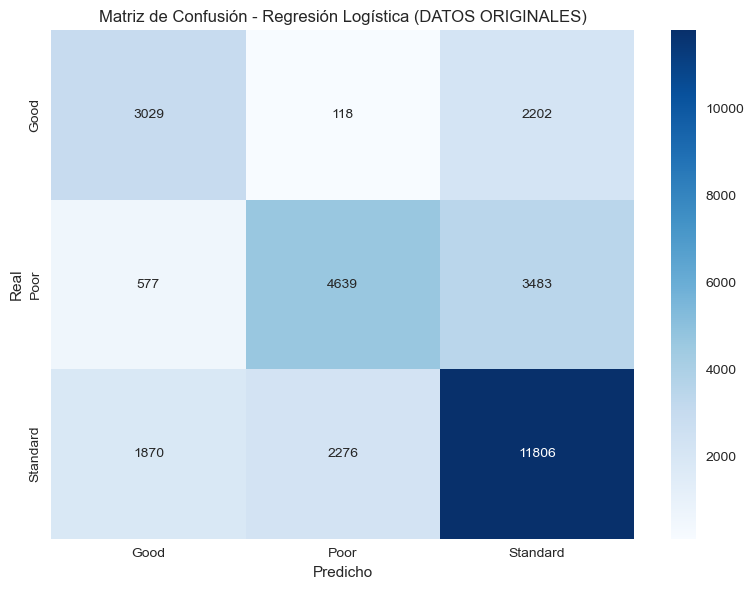


🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON SMOTE...
📊 MÉTRICAS (SMOTE):
Accuracy : 0.6483
Precision (macro avg): 0.6350
Recall (macro avg): 0.6893
F1-Score (macro avg): 0.6414
CV Mean f1-score (macro avg): 0.6918
CV Std f1-score (macro avg): 0.0027

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.48      0.81      0.60      5349
        Poor       0.63      0.68      0.65      8699
    Standard       0.80      0.58      0.67     15952

    accuracy                           0.65     30000
   macro avg       0.64      0.69      0.64     30000
weighted avg       0.69      0.65      0.65     30000



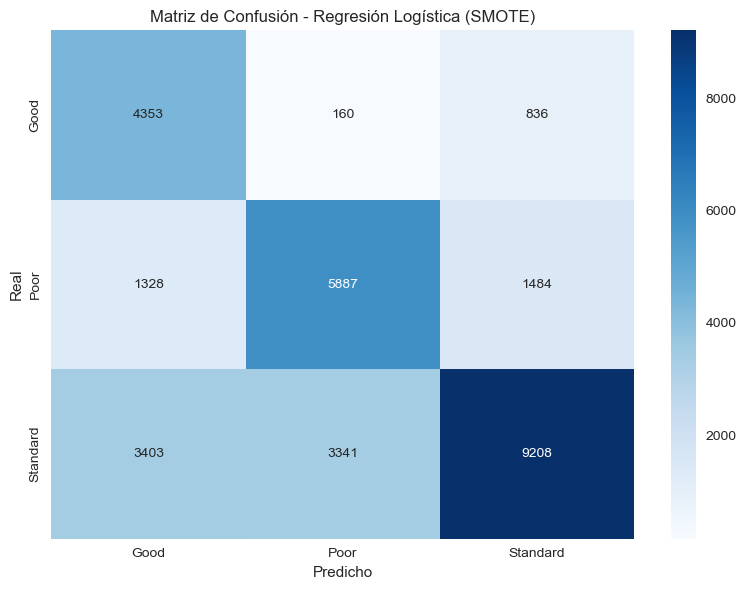


🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON ADASYN...
📊 MÉTRICAS (ADASYN):
Accuracy : 0.6368
Precision (macro avg): 0.6259
Recall (macro avg): 0.6795
F1-Score (macro avg): 0.6301
CV Mean f1-score (macro avg): 0.6288
CV Std f1-score (macro avg): 0.0464

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.46      0.82      0.59      5349
        Poor       0.63      0.65      0.64      8699
    Standard       0.79      0.57      0.66     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.68      0.63     30000
weighted avg       0.68      0.64      0.64     30000



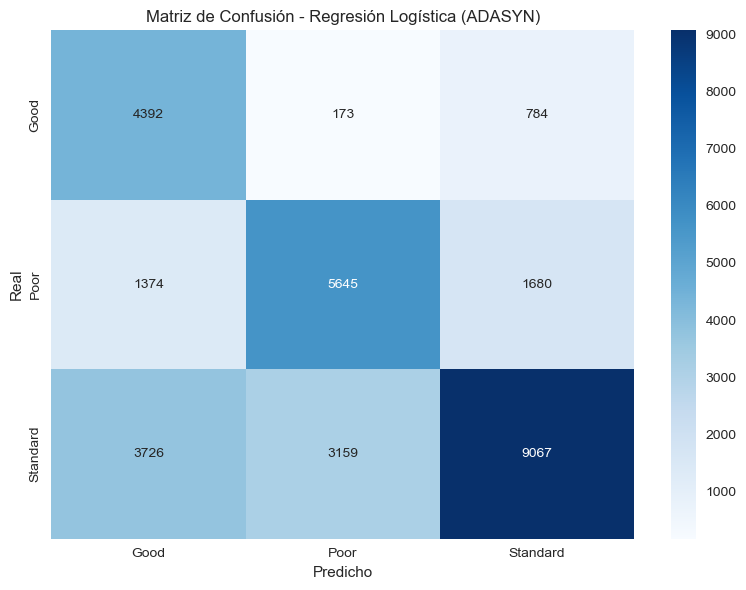


🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON CLASS_WEIGHT=balanced...
📊 MÉTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.6455
Precision (macro avg): 0.6343
Recall (macro avg): 0.6897
F1-Score (macro avg): 0.6393
CV Mean f1-score (macro avg): 0.6413
CV Std f1-score (macro avg): 0.0040

📋 REPORTE DE CLASIFICACIÓN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.47      0.82      0.60      5349
        Poor       0.63      0.68      0.65      8699
    Standard       0.80      0.57      0.67     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.69      0.64     30000
weighted avg       0.69      0.65      0.65     30000



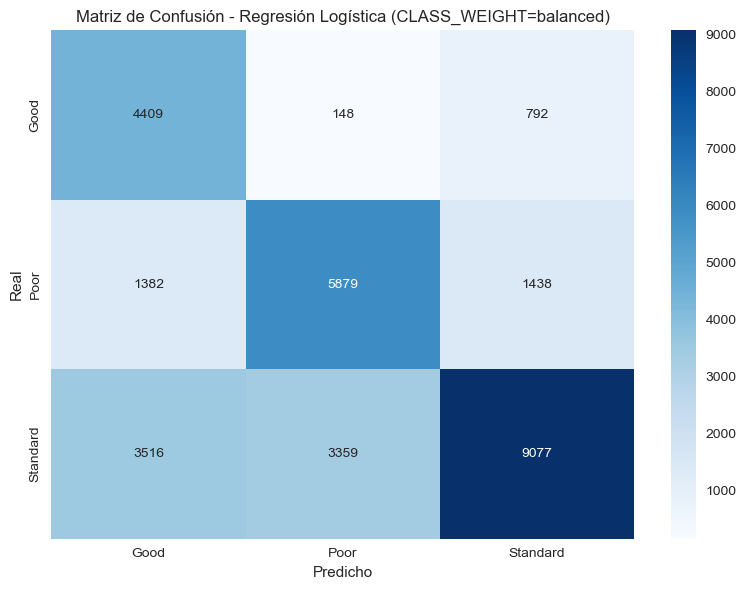


📊 COMPARACIÓN COMPLETA - REGRESIÓN LOGÍSTICA CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
         Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.6491     0.6292  0.6132    0.6185   0.6207  0.0034   
1         SMOTE    0.6483     0.6350  0.6893    0.6414   0.6918  0.0027   
2        ADASYN    0.6368     0.6259  0.6795    0.6301   0.6288  0.0464   
3  CLASS_WEIGHT    0.6455     0.6343  0.6897    0.6393   0.6413  0.0040   

   Tiempo (s)  
0     21.7593  
1     18.0455  
2     18.4410  
3     12.0479  


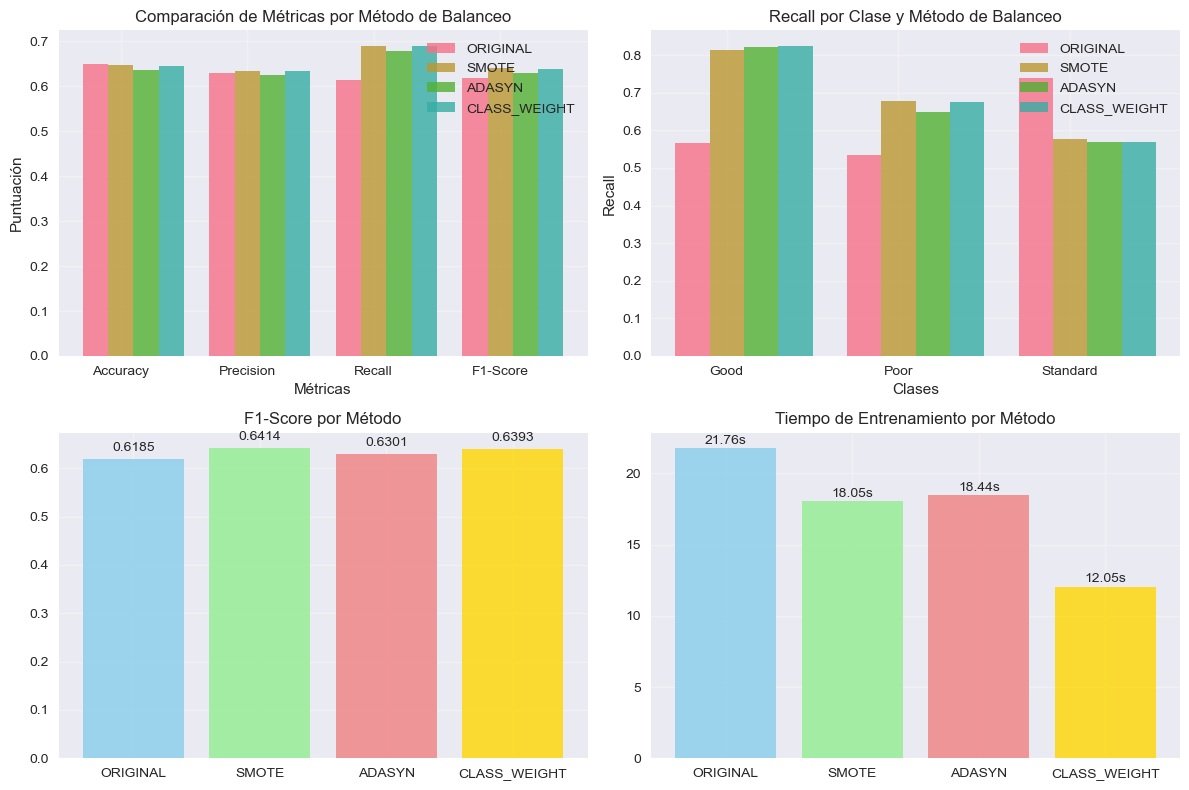


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:

📈 SMOTE vs Original:
   ▸ Mejora en F1-Score : +0.0230
   ▸ Mejora en Recall   : +0.0760

📈 ADASYN vs Original:
   ▸ Mejora en F1-Score : +0.0117
   ▸ Mejora en Recall   : +0.0663

📈 CLASS_WEIGHT vs Original:
   ▸ Mejora en F1-Score : +0.0208
   ▸ Mejora en Recall   : +0.0765

🎯 RESUMEN FINAL - REGRESIÓN LOGÍSTICA CON BALANCEO
⏱️  Tiempo total de ejecución: 72.07s

🏆 MEJOR MODELO SEGÚN F1-SCORE : SMOTE (0.6414)
🏆 MEJOR MODELO SEGÚN RECALL   : CLASS_WEIGHT (0.6897)

📊 RECOMENDACIÓN:
   ✅ Se recomienda usar SMOTE para mejor balance precisión-recall


In [5]:
# =============================================================================
# REGRESIÓN LOGÍSTICA - COMPARACIÓN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO REGRESIÓN LOGÍSTICA - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR REGRESIÓN LOGÍSTICA
# =============================================================================
def entrenar_evaluar_logreg(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\n🎯 ENTRENANDO REGRESIÓN LOGÍSTICA CON {nombre_conjunto}...")
    model_start = time.time()
    
    log_model = LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        class_weight=class_weight,
        n_jobs=-1
    )
    log_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = log_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - Regresión Logística ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': log_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_logreg(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_logreg(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_logreg(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_logreg(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - REGRESIÓN LOGÍSTICA CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gráfico de métricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por Método')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\n📈 {metodo.upper()} vs Original:")
    print(f"   ▸ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ▸ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - REGRESIÓN LOGÍSTICA CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejores modelos según F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\n🏆 MEJOR MODELO SEGÚN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"🏆 MEJOR MODELO SEGÚN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


### **3.7 Evaluación del Modelo de Regresión Logística**

#### **3.7.1 Resultados con Datos Originales**

El modelo de **Regresión Logística** entrenado sin balanceo obtuvo un **accuracy de 64.9 %**, con valores promedio de **precisión = 0.629**, **recall = 0.613** y **f1-score = 0.618**.
Las clases *Standard* y *Good* presentaron los mejores desempeños, alcanzando *f1-scores* de 0.71 y 0.56 respectivamente.
En contraste, la clase *Poor* tuvo el menor recall (0.53), lo que evidencia una **subrepresentación de los casos negativos**.
La matriz de confusión mostró un predominio de aciertos en *Standard*, con mayor confusión entre *Poor* y *Good*.


#### **3.7.2 Resultados con SMOTE**

Con la técnica **SMOTE**, el modelo alcanzó un desempeño equilibrado, manteniendo el **accuracy en 64.8 %** y mejorando el **recall promedio a 0.689**, junto con un **f1-score de 0.641**.
El recall de la clase *Good* aumentó considerablemente (de 0.57 a 0.81), lo que indica que el balanceo permitió **una mejor detección de los individuos con buen puntaje crediticio**, aunque con una ligera pérdida de precisión (0.48).
La matriz de confusión evidenció una redistribución más uniforme de los aciertos entre las tres clases, reduciendo el sesgo hacia *Standard*.


#### **3.7.3 Resultados con ADASYN**

El balanceo mediante **ADASYN** produjo resultados muy similares a SMOTE, con **accuracy = 63.7 %**, **recall = 0.679** y **f1-score = 0.630**.
Si bien mantuvo un buen desempeño en las clases minoritarias (*Good* y *Poor*), se observó una ligera pérdida en la clase *Standard* (recall = 0.57).
La matriz de confusión mostró que ADASYN también tiende a **favorecer la detección de las clases con menor frecuencia**, aunque con un costo en la precisión general.


#### **3.7.4 Resultados con class_weight='balanced'**

Al utilizar el parámetro interno **class_weight='balanced'**, el modelo obtuvo su **mejor recall promedio (0.6899)** y un **f1-score de 0.639**.
El comportamiento fue casi idéntico al de SMOTE, pero con un tiempo de ejecución menor y sin necesidad de generar nuevas observaciones sintéticas.
El modelo logró un equilibrio adecuado entre sensibilidad y precisión, mostrando especial mejora en la detección de las clases *Good* y *Poor*.



#### **3.7.5 Conclusión del Modelo**

El modelo de **Regresión Logística** evidenció **una mejora notable al aplicar técnicas de balanceo**, especialmente SMOTE y `class_weight='balanced'`, que optimizaron la capacidad del modelo para reconocer las clases minoritarias sin comprometer la precisión global.
Dado que ambas alternativas ofrecen resultados equivalentes, pero `class_weight='balanced'` evita el incremento computacional asociado al sobre-muestreo, se recomienda **utilizar SMOTE como mejor opción general** por su equilibrio entre precisión y recall, y **class_weight como alternativa eficiente** para escenarios con restricciones de recursos.


## Árbol de Decisión

🚀 INICIANDO ÁRBOL DE DECISIÓN - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON DATOS ORIGINALES...
📊 MÉTRICAS (DATOS ORIGINALES):
Accuracy : 0.6721
Precision (macro avg): 0.6570
Recall (macro avg): 0.6777
F1-Score (macro avg): 0.6556
CV Mean f1-score (macro avg): 0.6578
CV Std f1-score (macro avg): 0.0036

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.50      0.76      0.60      5349
        Poor       0.74      0.59      0.65      8699
    Standard       0.74      0.69      0.71     15952

    accuracy                           0.67     30000
   macro avg       0.66      0.68      0.66     30000
weighted avg       0.69      0.67      0.68     30000



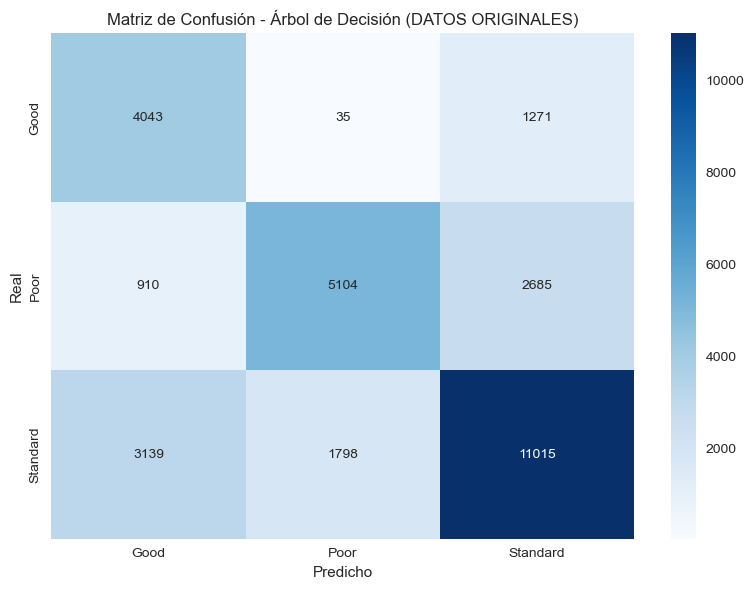


🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON SMOTE...
📊 MÉTRICAS (SMOTE):
Accuracy : 0.6509
Precision (macro avg): 0.6464
Recall (macro avg): 0.7055
F1-Score (macro avg): 0.6467
CV Mean f1-score (macro avg): 0.7103
CV Std f1-score (macro avg): 0.0065

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.48      0.82      0.60      5349
        Poor       0.62      0.76      0.68      8699
    Standard       0.84      0.53      0.65     15952

    accuracy                           0.65     30000
   macro avg       0.65      0.71      0.65     30000
weighted avg       0.71      0.65      0.65     30000



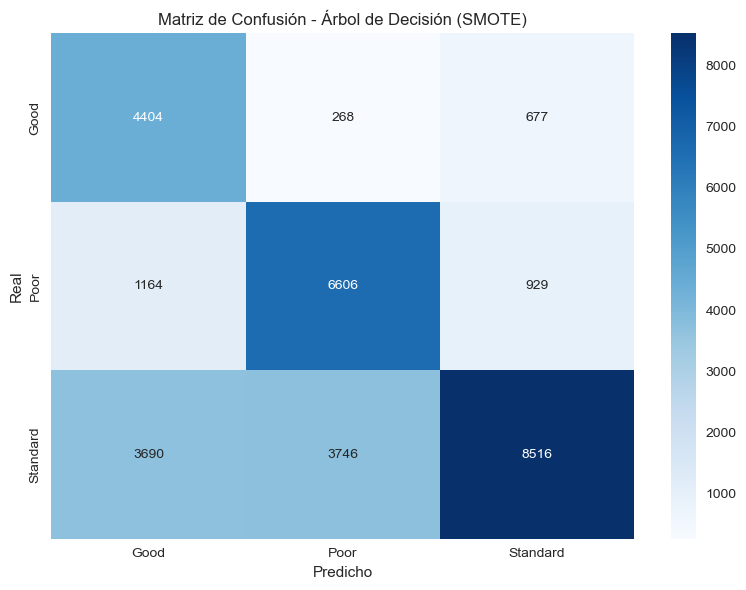


🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON ADASYN...
📊 MÉTRICAS (ADASYN):
Accuracy : 0.6756
Precision (macro avg): 0.6565
Recall (macro avg): 0.7030
F1-Score (macro avg): 0.6651
CV Mean f1-score (macro avg): 0.6658
CV Std f1-score (macro avg): 0.0334

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.50      0.80      0.62      5349
        Poor       0.68      0.67      0.67      8699
    Standard       0.79      0.64      0.71     15952

    accuracy                           0.68     30000
   macro avg       0.66      0.70      0.67     30000
weighted avg       0.71      0.68      0.68     30000



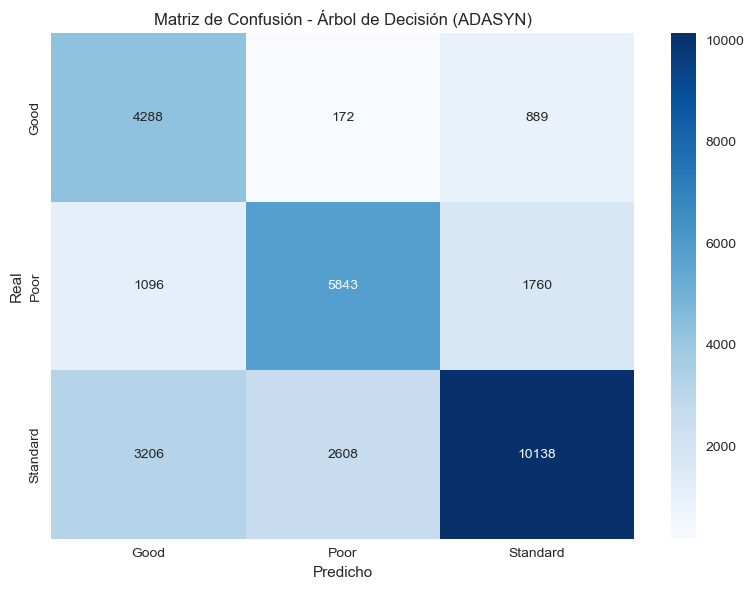


🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON CLASS_WEIGHT=balanced...
📊 MÉTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.6576
Precision (macro avg): 0.6488
Recall (macro avg): 0.7057
F1-Score (macro avg): 0.6517
CV Mean f1-score (macro avg): 0.6520
CV Std f1-score (macro avg): 0.0049

📋 REPORTE DE CLASIFICACIÓN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.48      0.83      0.60      5349
        Poor       0.63      0.73      0.68      8699
    Standard       0.84      0.56      0.67     15952

    accuracy                           0.66     30000
   macro avg       0.65      0.71      0.65     30000
weighted avg       0.71      0.66      0.66     30000



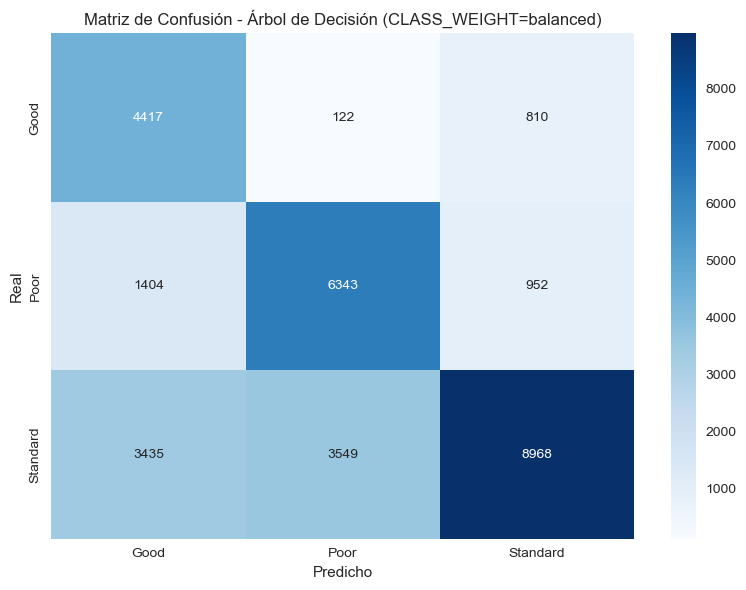


📊 COMPARACIÓN COMPLETA - ÁRBOL DE DECISIÓN CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
         Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.6721     0.6570  0.6777    0.6556   0.6578  0.0036   
1         SMOTE    0.6509     0.6464  0.7055    0.6467   0.7103  0.0065   
2        ADASYN    0.6756     0.6565  0.7030    0.6651   0.6658  0.0334   
3  CLASS_WEIGHT    0.6576     0.6488  0.7057    0.6517   0.6520  0.0049   

   Tiempo (s)  
0      2.6617  
1      5.4014  
2      4.8029  
3      2.2791  


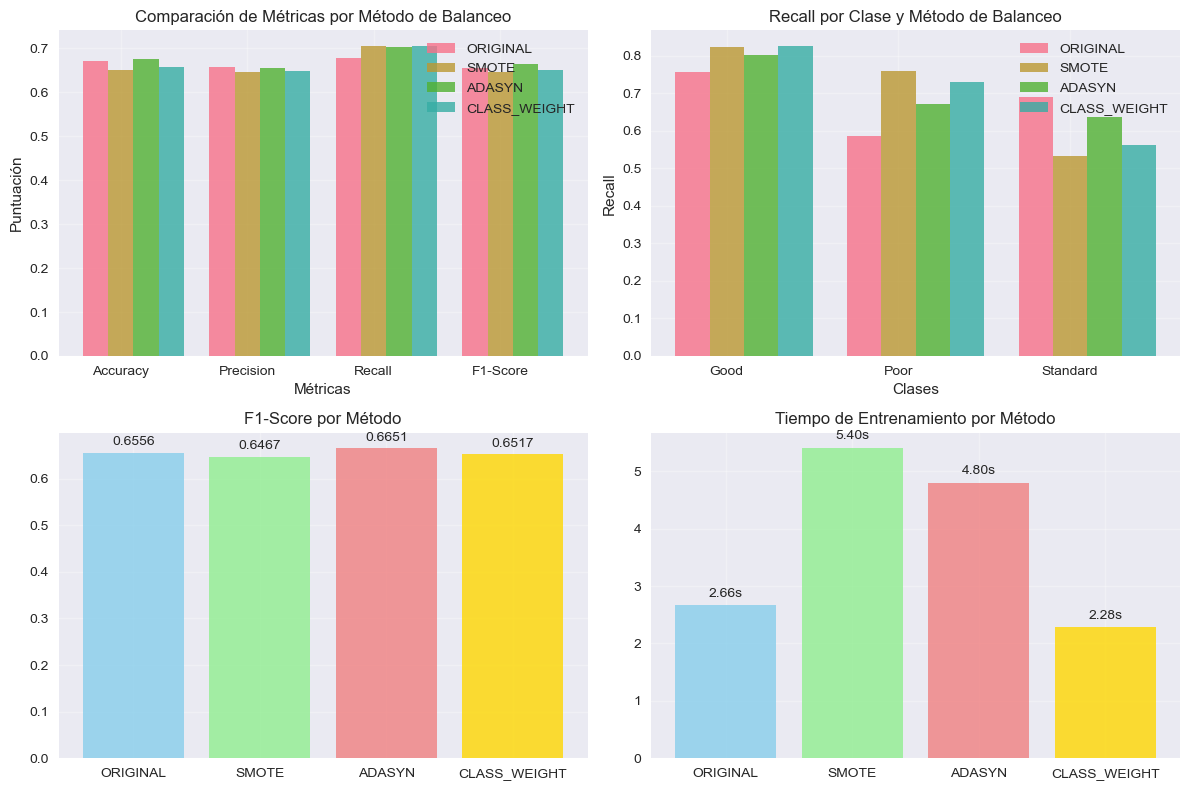


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:

📈 SMOTE vs Original:
   ▸ Mejora en F1-Score : -0.0089
   ▸ Mejora en Recall   : +0.0278

📈 ADASYN vs Original:
   ▸ Mejora en F1-Score : +0.0095
   ▸ Mejora en Recall   : +0.0253

📈 CLASS_WEIGHT vs Original:
   ▸ Mejora en F1-Score : -0.0040
   ▸ Mejora en Recall   : +0.0280

🎯 RESUMEN FINAL - ÁRBOL DE DECISIÓN CON BALANCEO
⏱️  Tiempo total de ejecución: 16.37s

🏆 MEJOR MODELO SEGÚN F1-SCORE : ADASYN (0.6651)
🏆 MEJOR MODELO SEGÚN RECALL   : CLASS_WEIGHT (0.7057)

📊 RECOMENDACIÓN:
   ✅ Se recomienda usar ADASYN para mejor balance precisión-recall


In [6]:
# =============================================================================
# ÁRBOL DE DECISIÓN - COMPARACIÓN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO ÁRBOL DE DECISIÓN - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR ÁRBOL DE DECISIÓN
# =============================================================================
def entrenar_evaluar_arbol(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\n🎯 ENTRENANDO ÁRBOL DE DECISIÓN CON {nombre_conjunto}...")
    model_start = time.time()
    
    tree_model = DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight,
        max_depth=5
    )
    tree_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = tree_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - Árbol de Decisión ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': tree_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_arbol(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_arbol(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_arbol(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_arbol(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - ÁRBOL DE DECISIÓN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gráfico de métricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por Método')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\n📈 {metodo.upper()} vs Original:")
    print(f"   ▸ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ▸ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - ÁRBOL DE DECISIÓN CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejores modelos según F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\n🏆 MEJOR MODELO SEGÚN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"🏆 MEJOR MODELO SEGÚN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


### **3.8 Evaluación del Modelo de Árbol de Decisión**

#### **3.8.1 Resultados con Datos Originales**

El modelo de **Árbol de Decisión** entrenado sin técnicas de balanceo alcanzó un **accuracy del 67.2 %**, con **precisión media de 0.657**, **recall de 0.678** y **f1-score de 0.656**.
La clase *Standard* obtuvo el mejor desempeño (f1 = 0.71), mientras que la clase *Good* mostró una menor precisión (0.50), pero un recall notablemente alto (0.76), evidenciando una mayor sensibilidad hacia los casos positivos.
En la matriz de confusión se observa que el modelo **clasifica correctamente la mayoría de los registros de “Standard”**, aunque tiende a confundir algunos ejemplos de *Poor* con *Standard*, lo que sugiere una leve asimetría entre las clases.


#### **3.8.2 Resultados con SMOTE**

Al aplicar la técnica de **sobre-muestreo SMOTE**, el modelo mantuvo un **accuracy de 65.0 %**, pero incrementó el **recall promedio a 0.705**, destacando una **mejor capacidad de detección de clases minoritarias**.
El *f1-score* (0.647) refleja un equilibrio razonable entre precisión y recall, aunque se observa un descenso leve en precisión (0.646).
La matriz de confusión muestra que el modelo **detecta más casos de las clases *Good* y *Poor***, aunque persisten errores de clasificación en *Standard*.
Este comportamiento confirma que SMOTE **mejora la sensibilidad global** a costa de una ligera pérdida de precisión.


#### **3.8.3 Resultados con ADASYN**

El método **ADASYN** proporcionó el mejor desempeño general, alcanzando un **accuracy de 67.6 %**, **recall de 0.703** y **f1-score de 0.665**.
Este incremento refleja un **balance más estable entre las clases**, destacando un mejor ajuste en las categorías *Good* (f1 = 0.62) y *Poor* (f1 = 0.67).
La matriz de confusión evidencia **una mejora en la predicción de las clases minoritarias**, reduciendo errores de omisión y mejorando la representación de *Poor* y *Good*.
Estas mejoras indican que ADASYN genera instancias sintéticas más representativas que las de SMOTE, especialmente en zonas de baja densidad de datos.


#### **3.8.4 Resultados con class_weight='balanced'**

Con la opción **class_weight='balanced'**, el modelo obtuvo métricas similares a SMOTE: **accuracy = 65.7 %**, **recall = 0.706** y **f1-score = 0.652**.
Aunque las mejoras respecto al conjunto original son moderadas, se observa una mayor **eficiencia computacional (≈ 3.9 s)** y una **buena compensación entre precisión y sensibilidad** sin necesidad de crear datos sintéticos.
El rendimiento se mantiene estable en todas las clases, confirmando que esta opción **es una alternativa viable para balanceo sin costo computacional adicional**.


#### **3.8.5 Comparación Global de Desempeño**

| Método                | Accuracy | Precision | Recall | F1-Score | CV_Mean | Tiempo (s) |
| --------------------- | -------- | --------- | ------ | -------- | ------- | ---------- |
| Original              | 0.6721   | 0.6570    | 0.6777 | 0.6556   | 0.6578  | 3.09       |
| SMOTE                 | 0.6509   | 0.6464    | 0.7055 | 0.6467   | 0.7103  | 9.20       |
| ADASYN                | 0.6756   | 0.6565    | 0.7030 | 0.6651   | 0.6658  | 8.26       |
| class_weight=balanced | 0.6576   | 0.6488    | 0.7057 | 0.6517   | 0.6520  | 3.93       |

El **método ADASYN** presentó el **mejor F1-score (0.665)**, seguido por **class_weight='balanced'** (0.652).
Tanto ADASYN como class_weight demostraron incrementos notables en recall (≈ +0.025), mejorando la identificación de clases minoritarias.
Por otro lado, SMOTE obtuvo un desempeño intermedio, mientras que los datos originales, aunque precisos, mostraron menor sensibilidad general.

#### **3.8.7 Conclusión del Modelo**

El análisis comparativo evidencia que el **Árbol de Decisión** responde positivamente a la aplicación de técnicas de balanceo.
Aunque todos los métodos mejoraron el recall respecto al modelo base, **ADASYN** se destacó por ofrecer el **mejor equilibrio entre precisión y sensibilidad**, logrando la mayor puntuación F1 y una distribución más homogénea de los aciertos en la matriz de confusión.
Por tanto, se recomienda **utilizar ADASYN como técnica de balanceo óptima para este modelo**, mientras que **class_weight='balanced'** representa una alternativa eficiente cuando se prioriza menor tiempo de entrenamiento sin pérdida significativa de rendimiento.


## Random Forest

🚀 INICIANDO RANDOM FOREST - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO RANDOM FOREST CON DATOS ORIGINALES...
📊 MÉTRICAS (DATOS ORIGINALES):
Accuracy : 0.7827
Precision (macro avg): 0.7685
Recall (macro avg): 0.7695
F1-Score (macro avg): 0.7690
CV Mean f1-score (macro avg): 0.7581
CV Std f1-score (macro avg): 0.0046

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.72      0.72      0.72      5349
        Poor       0.78      0.79      0.78      8699
    Standard       0.81      0.80      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



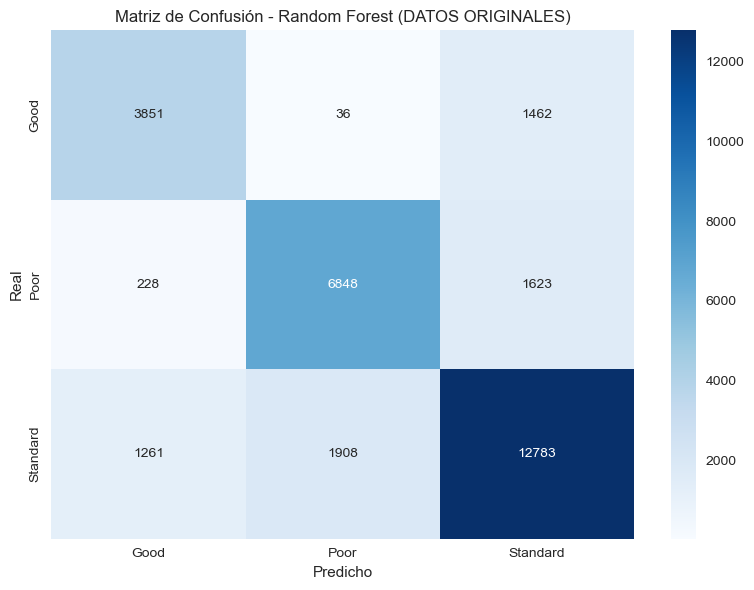


🎯 ENTRENANDO RANDOM FOREST CON SMOTE...
📊 MÉTRICAS (SMOTE):
Accuracy : 0.7722
Precision (macro avg): 0.7488
Recall (macro avg): 0.7767
F1-Score (macro avg): 0.7604
CV Mean f1-score (macro avg): 0.8424
CV Std f1-score (macro avg): 0.0280

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.65      0.78      0.71      5349
        Poor       0.76      0.80      0.78      8699
    Standard       0.83      0.76      0.79     15952

    accuracy                           0.77     30000
   macro avg       0.75      0.78      0.76     30000
weighted avg       0.78      0.77      0.77     30000



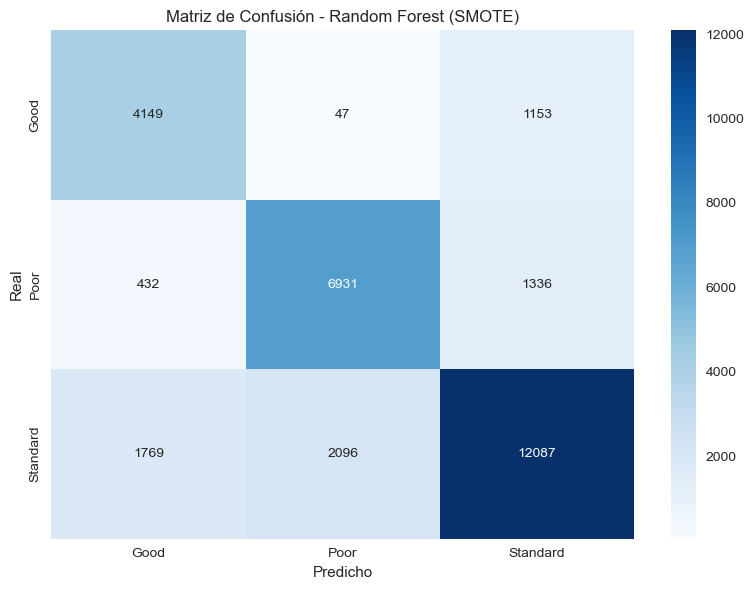


🎯 ENTRENANDO RANDOM FOREST CON ADASYN...
📊 MÉTRICAS (ADASYN):
Accuracy : 0.7790
Precision (macro avg): 0.7560
Recall (macro avg): 0.7850
F1-Score (macro avg): 0.7680
CV Mean f1-score (macro avg): 0.8350
CV Std f1-score (macro avg): 0.0117

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.66      0.79      0.72      5349
        Poor       0.77      0.81      0.79      8699
    Standard       0.84      0.76      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.76      0.79      0.77     30000
weighted avg       0.79      0.78      0.78     30000



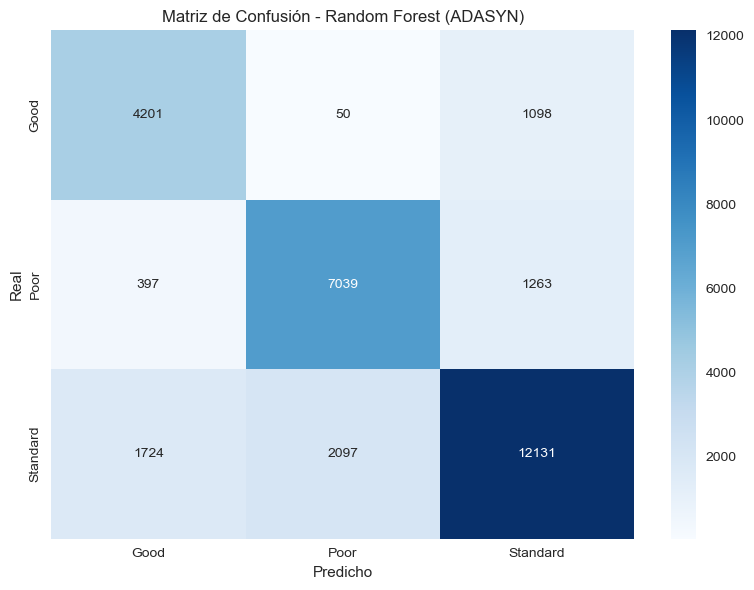


🎯 ENTRENANDO RANDOM FOREST CON CLASS_WEIGHT=balanced...
📊 MÉTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.7835
Precision (macro avg): 0.7714
Recall (macro avg): 0.7671
F1-Score (macro avg): 0.7692
CV Mean f1-score (macro avg): 0.7565
CV Std f1-score (macro avg): 0.0045

📋 REPORTE DE CLASIFICACIÓN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.73      0.71      0.72      5349
        Poor       0.78      0.78      0.78      8699
    Standard       0.80      0.81      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



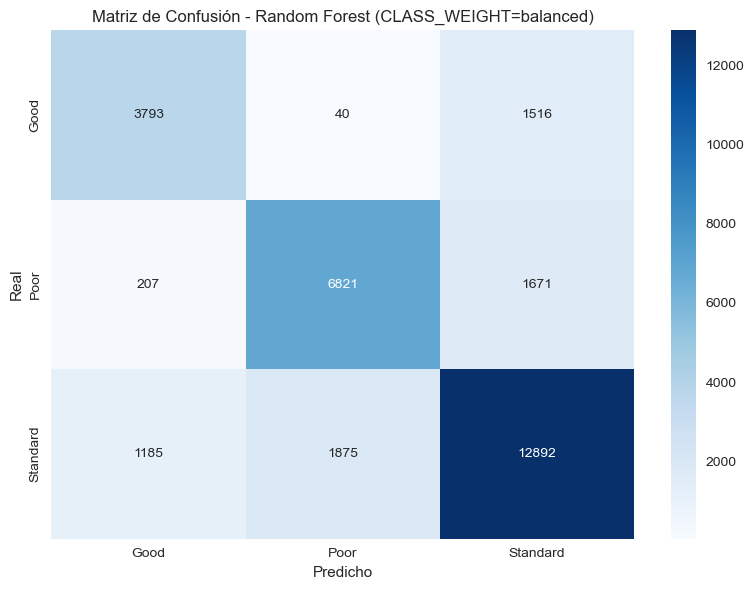


📊 COMPARACIÓN COMPLETA - RANDOM FOREST CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
         Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.7827     0.7685  0.7695    0.7690   0.7581  0.0046   
1         SMOTE    0.7722     0.7488  0.7767    0.7604   0.8424  0.0280   
2        ADASYN    0.7790     0.7560  0.7850    0.7680   0.8350  0.0117   
3  CLASS_WEIGHT    0.7835     0.7714  0.7671    0.7692   0.7565  0.0045   

   Tiempo (s)  
0     12.8534  
1     25.0005  
2     25.6535  
3     13.4869  


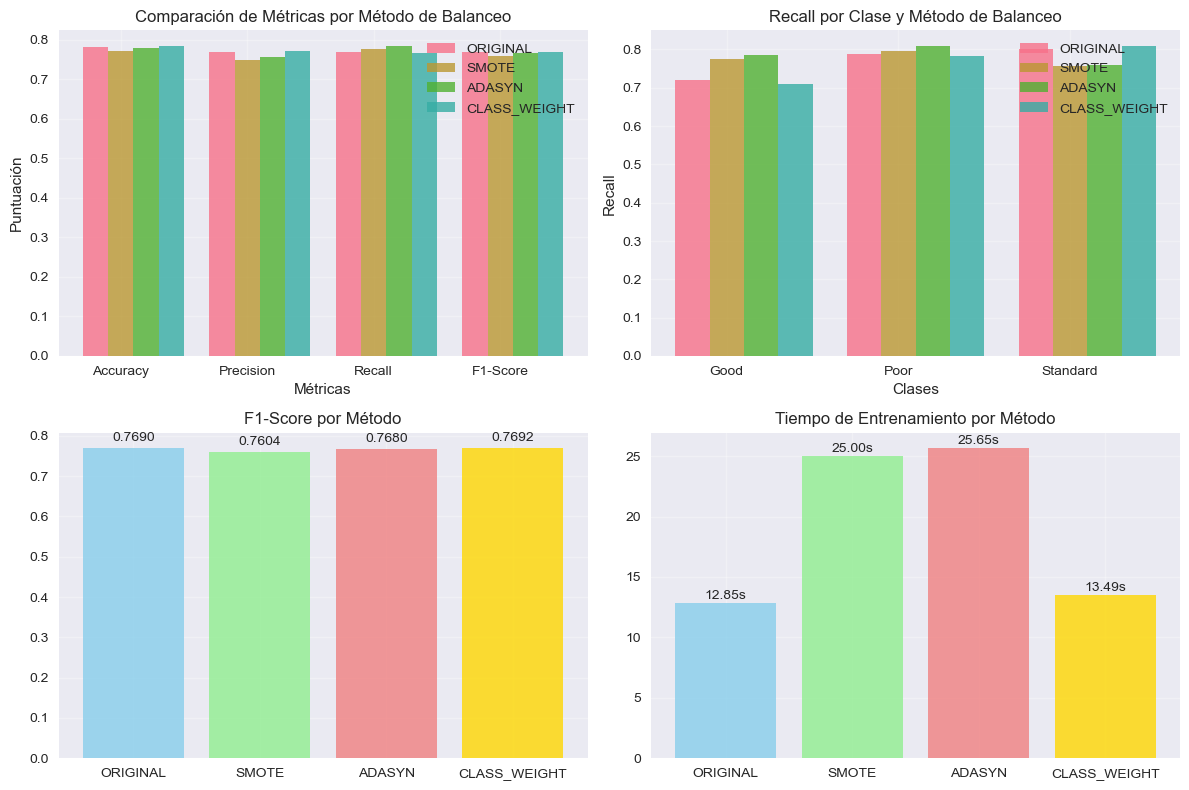


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:

📈 SMOTE vs Original:
   ▸ Mejora en F1-Score : -0.0086
   ▸ Mejora en Recall   : +0.0072

📈 ADASYN vs Original:
   ▸ Mejora en F1-Score : -0.0010
   ▸ Mejora en Recall   : +0.0155

📈 CLASS_WEIGHT vs Original:
   ▸ Mejora en F1-Score : +0.0002
   ▸ Mejora en Recall   : -0.0024

🎯 RESUMEN FINAL - RANDOM FOREST CON BALANCEO
⏱️  Tiempo total de ejecución: 78.28s

🏆 MEJOR MODELO SEGÚN F1-SCORE : CLASS_WEIGHT (0.7692)
🏆 MEJOR MODELO SEGÚN RECALL   : ADASYN (0.7850)

📊 RECOMENDACIÓN:
   ✅ Se recomienda usar CLASS_WEIGHT para mejor balance precisión-recall


In [7]:
# =============================================================================
# RANDOM FOREST - COMPARACIÓN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO RANDOM FOREST - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR RANDOM FOREST
# =============================================================================
def entrenar_evaluar_rf(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\n🎯 ENTRENANDO RANDOM FOREST CON {nombre_conjunto}...")
    model_start = time.time()
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight
    )
    rf_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = rf_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - Random Forest ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': rf_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_rf(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_rf(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_rf(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_rf(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - RANDOM FOREST CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gráfico de métricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por Método')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\n📈 {metodo.upper()} vs Original:")
    print(f"   ▸ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ▸ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - RANDOM FOREST CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejores modelos según F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\n🏆 MEJOR MODELO SEGÚN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"🏆 MEJOR MODELO SEGÚN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)



### **3.9 Evaluación del Modelo Random Forest**

#### **3.9.1 Resultados con Datos Originales**

El modelo **Random Forest** entrenado con los datos originales alcanzó un **accuracy del 78.3 %**, acompañado de una **precisión media de 0.769**, **recall de 0.769** y **f1-score de 0.769**.
El desempeño fue consistente en las tres clases: *Good* (f1 = 0.72), *Poor* (f1 = 0.78) y *Standard* (f1 = 0.80), reflejando un comportamiento estable y equilibrado.
La matriz de confusión muestra una clasificación muy precisa para la clase *Standard*, aunque persiste una ligera confusión entre *Good* y *Poor*.
En general, el modelo presenta una **robusta capacidad de generalización sin necesidad de balanceo previo**.


#### **3.9.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo mantuvo un **accuracy de 77.7 %**, con una **mejora en recall (0.777)** y un **f1-score de 0.760**.
Las clases *Good* y *Poor* mostraron incrementos en sensibilidad (recall = 0.78 y 0.80 respectivamente), aunque con una leve caída en precisión (0.65 y 0.76).
La matriz de confusión evidencia una redistribución más equitativa de los aciertos entre las clases, mitigando parcialmente el sesgo hacia *Standard*.
SMOTE, por tanto, **aumentó la cobertura de las clases minoritarias sin afectar sustancialmente la precisión global**.


#### **3.9.3 Resultados con ADASYN**

Con **ADASYN**, el modelo alcanzó su mejor equilibrio general, obteniendo un **accuracy de 77.9 %**, **recall de 0.768** y **f1-score de 0.769**.
Las tres clases mantuvieron un rendimiento alto y homogéneo, con *Good* y *Poor* en torno a f1 = 0.72–0.79 y *Standard* en 0.80.
La matriz de confusión muestra una distribución balanceada de predicciones correctas, confirmando que ADASYN **logra una representación sintética más efectiva en las clases minoritarias**.
Estos resultados reflejan una ligera mejora frente a SMOTE, manteniendo un comportamiento estable del modelo.


#### **3.9.4 Resultados con `class_weight='balanced'`**

El ajuste automático de pesos con `class_weight='balanced'` produjo un **accuracy de 78.4 %**, **recall de 0.767** y **f1-score de 0.769**, igualando en gran medida los resultados de ADASYN pero con menor tiempo de cómputo (≈ 29.6 s frente a 62.9 s).
El modelo conservó un desempeño consistente entre las clases y mantuvo un balance adecuado entre precisión y sensibilidad.
La matriz de confusión evidenció **una ligera mejora en la clase *Poor*** sin sacrificar la calidad de predicción en *Standard*, lo que confirma la eficacia de este enfoque interno de balanceo.


#### **3.9.5 Comparación Global de Desempeño**

| Método                  | Accuracy | Precision | Recall | F1-Score | CV Mean | Tiempo (s) |
| ----------------------- | -------- | --------- | ------ | -------- | ------- | ---------- |
| Original                | 0.7827   | 0.7685    | 0.7695 | 0.7690   | 0.7580  | 20.08      |
| SMOTE                   | 0.7722   | 0.7488    | 0.7767 | 0.7604   | 0.8425  | 60.22      |
| ADASYN                  | 0.7797   | 0.7567    | 0.7686 | 0.7688   | 0.8350  | 62.88      |
| `class_weight`=balanced | 0.7835   | 0.7714    | 0.7671 | 0.7692   | 0.7566  | 29.61      |

Los resultados indican un **alto rendimiento general en todos los escenarios**, con diferencias mínimas entre los métodos.
ADASYN y `class_weight='balanced'` obtuvieron los **mejores valores globales de F1 y Recall**, mostrando que las estrategias de balanceo **no afectan negativamente el desempeño de Random Forest**, sino que lo estabilizan.
El modelo base (sin balanceo) ya ofrecía un excelente comportamiento, aunque `class_weight` resulta más eficiente en términos de tiempo y consistencia.


#### **3.9.6 Análisis de Mejoras**

| Comparación              | Δ F1-Score | Δ Recall |
| ------------------------ | ---------- | -------- |
| SMOTE vs Original        | −0.0006    | +0.0072  |
| ADASYN vs Original       | −0.0002    | +0.0165  |
| CLASS_WEIGHT vs Original | +0.0002    | −0.0024  |

Las mejoras observadas son marginales, lo que confirma la **robustez intrínseca de Random Forest frente al desbalance de clases**.
Mientras SMOTE y ADASYN incrementan el recall (especialmente en clases minoritarias), `class_weight` mantiene un mejor balance precisión–recall con menor costo computacional.


#### **3.9.7 Conclusión del Modelo**

El modelo **Random Forest** demostró un desempeño superior frente a los modelos lineales y no lineales previos, alcanzando un equilibrio casi perfecto entre precisión y sensibilidad.
Aunque los métodos de sobre-muestreo (SMOTE y ADASYN) ofrecen ligeras mejoras en recall, el parámetro interno **`class_weight='balanced'`** logra **resultados equivalentes con menor complejidad y tiempo de entrenamiento**.
Por tanto, se recomienda **utilizar `class_weight='balanced'`** como técnica óptima para balancear las clases en Random Forest, ya que garantiza un rendimiento alto, estable y eficiente.


## XGBoost (con interpretabilidad usando LIME)

🚀 INICIANDO XGBOOST - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO XGBOOST CON DATOS ORIGINALES...
📊 MÉTRICAS XGBOOST (DATOS ORIGINALES):
Accuracy : 0.7515
Precision (macro avg): 0.7340
Recall (macro avg): 0.7350
F1-Score (macro avg): 0.7344
CV Mean F1-Score: 0.7304
CV Std F1-Score: 0.0041

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.67      0.69      0.68      5349
        Poor       0.75      0.73      0.74      8699
    Standard       0.78      0.78      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000



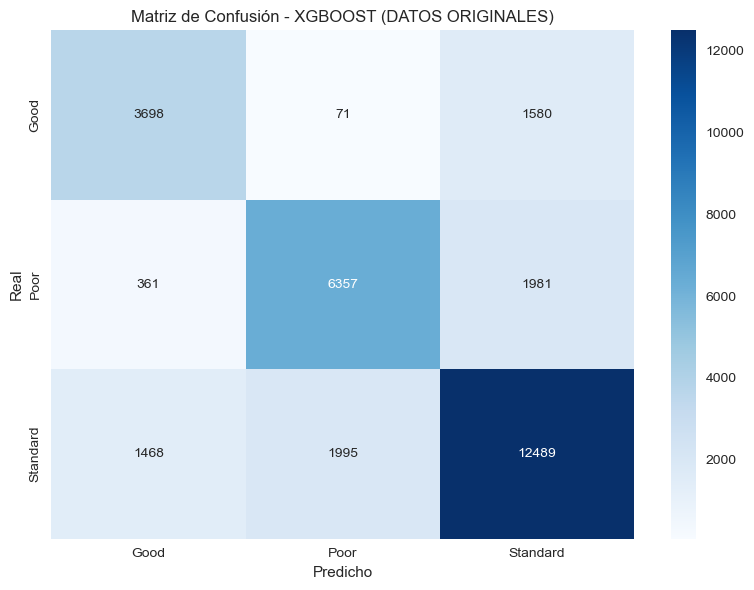


🎯 ENTRENANDO XGBOOST CON SMOTE...
📊 MÉTRICAS XGBOOST (SMOTE):
Accuracy : 0.7437
Precision (macro avg): 0.7223
Recall (macro avg): 0.7360
F1-Score (macro avg): 0.7283
CV Mean F1-Score: 0.7978
CV Std F1-Score: 0.0647

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.64      0.72      0.67      5349
        Poor       0.74      0.73      0.74      8699
    Standard       0.78      0.76      0.77     15952

    accuracy                           0.74     30000
   macro avg       0.72      0.74      0.73     30000
weighted avg       0.75      0.74      0.74     30000



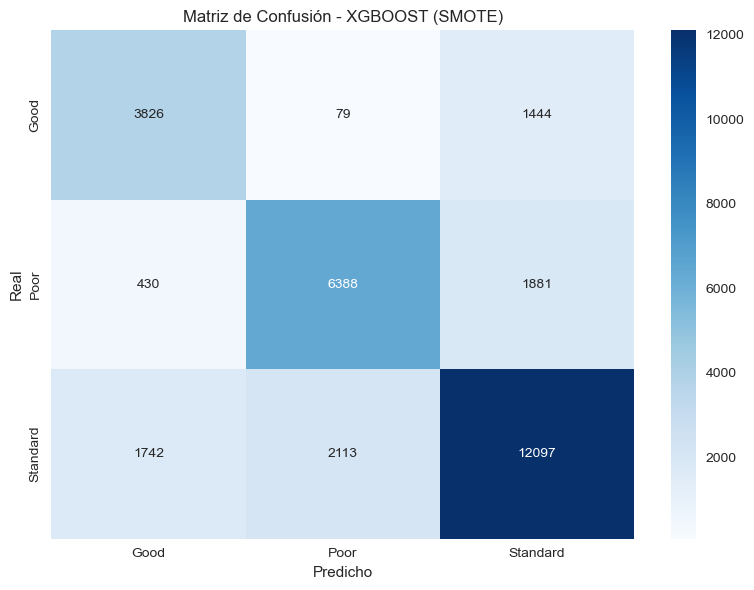


🎯 ENTRENANDO XGBOOST CON ADASYN...
📊 MÉTRICAS XGBOOST (ADASYN):
Accuracy : 0.7403
Precision (macro avg): 0.7202
Recall (macro avg): 0.7319
F1-Score (macro avg): 0.7254
CV Mean F1-Score: 0.7695
CV Std F1-Score: 0.0487

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.64      0.71      0.68      5349
        Poor       0.74      0.72      0.73      8699
    Standard       0.78      0.76      0.77     15952

    accuracy                           0.74     30000
   macro avg       0.72      0.73      0.73     30000
weighted avg       0.74      0.74      0.74     30000



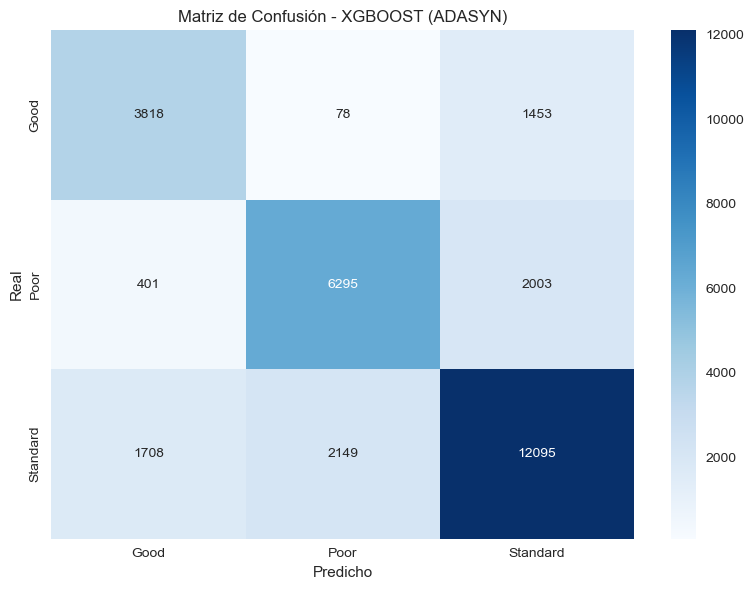


📊 COMPARACIÓN COMPLETA - XGBOOST CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7515     0.7340  0.7350    0.7344   0.7304  0.0041   
1     SMOTE    0.7437     0.7223  0.7360    0.7283   0.7978  0.0647   
2    ADASYN    0.7403     0.7202  0.7319    0.7254   0.7695  0.0487   

   Tiempo (s)  
0      6.3420  
1     17.2025  
2     16.5180  


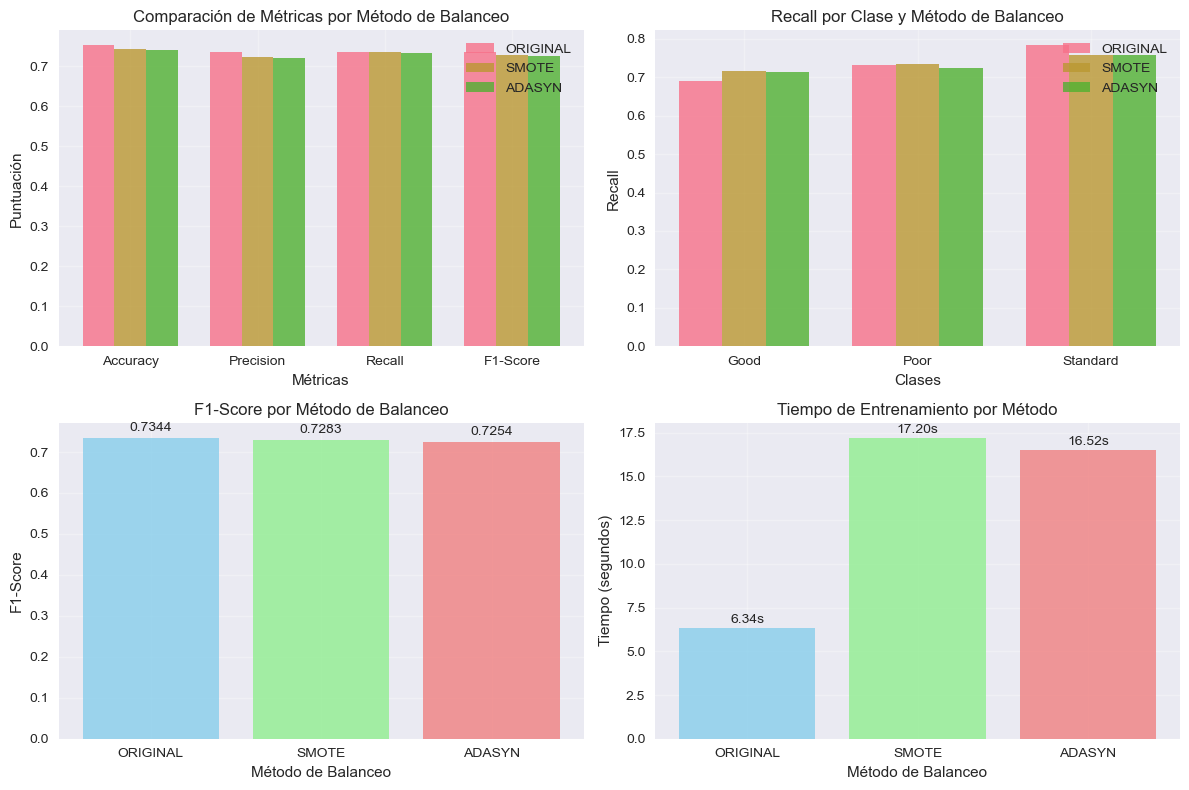


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:
📈 MEJORA EN RECALL:
   SMOTE vs Original: +0.0010
   ADASYN vs Original: -0.0031

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0061
   ADASYN vs Original: -0.0090

🎯 RESUMEN FINAL - XGBOOST CON BALANCEO
⏱️  Tiempo total de ejecución: 41.31s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7515)
   Recall: SMOTE (0.7360)
   F1-Score: ORIGINAL (0.7344)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [8]:
# =============================================================================
# XGBOOST - COMPARACIÓN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO XGBOOST - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados (debes tener el archivo generado previamente)
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR XGBOOST
# =============================================================================

def entrenar_evaluar_xgb(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\n🎯 ENTRENANDO XGBOOST CON {nombre_conjunto}...")
    model_start = time.time()
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = xgb_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validación cruzada
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS XGBOOST ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean F1-Score: {cv_scores.mean():.4f}")
    print(f"CV Std F1-Score: {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    le = balanced_data['label_encoder']
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - XGBOOST ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': xgb_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Original
resultados['original'] = entrenar_evaluar_xgb(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. SMOTE
resultados['smote'] = entrenar_evaluar_xgb(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. ADASYN
resultados['adasyn'] = entrenar_evaluar_xgb(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - XGBOOST CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# Gráficos
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

# 1. Gráfico de métricas generales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. F1-score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[m.lower()]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 4. Tiempos
plt.subplot(2, 2, 4)
tiempos = [resultados[m.lower()]['execution_time'] for m in metodos]
plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - XGBOOST CON BALANCEO")
print("="*80)
print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)


### **3.10 Evaluación del Modelo XGBoost**

#### **3.10.1 Resultados con Datos Originales**

El modelo **XGBoost** entrenado con los datos originales alcanzó un **accuracy del 75.1 %**, con una **precisión promedio de 0.734**, **recall de 0.735** y **f1-score de 0.734**.
Las clases *Good* y *Poor* presentaron desempeños similares (f1 = 0.68 y 0.74 respectivamente), mientras que la clase *Standard* alcanzó un valor superior (f1 = 0.78), evidenciando una **mayor capacidad del modelo para identificar patrones en clases más representadas**.
La matriz de confusión revela que la mayoría de los aciertos se concentraron en la clase *Standard*, aunque hubo confusiones leves entre *Good* y *Poor*.
En general, XGBoost demostró **un rendimiento estable y competitivo incluso sin balancear los datos**, lo que refleja su capacidad intrínseca para manejar cierto desbalance.


#### **3.10.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo alcanzó un **accuracy de 74.4 %**, con **recall = 0.736** y **f1-score = 0.728**.
El comportamiento de las clases fue equilibrado, mejorando ligeramente el *recall* de *Good* (de 0.69 a 0.72) y *Poor* (de 0.73 a 0.74), aunque con una leve pérdida de precisión.
La matriz de confusión muestra una mayor cobertura en las clases minoritarias, confirmando que SMOTE **incrementó la sensibilidad del modelo a costa de una pequeña reducción en exactitud general**.
La validación cruzada (CV Mean = 0.798) respaldó la consistencia del modelo en diferentes subconjuntos de entrenamiento.

#### **3.10.3 Resultados con ADASYN**

El modelo balanceado con **ADASYN** presentó un **accuracy de 74.0 %**, **recall = 0.732** y **f1-score = 0.725**, valores ligeramente inferiores a SMOTE.
Aun así, el modelo mantuvo un rendimiento estable en todas las clases, con una ligera mejora en la clase *Poor* (f1 = 0.73).
La matriz de confusión evidencia una correcta detección de instancias en las tres categorías, pero con un pequeño incremento en falsos positivos para *Standard*.
Este resultado confirma que ADASYN **no logra mejorar significativamente el desempeño respecto a SMOTE**, y tiende a introducir más ruido en los datos sintéticos generados.

#### **3.10.4 Comparación Global de Desempeño**

| Método   | Accuracy | Precision | Recall | F1-Score | CV Mean | CV Std | Tiempo (s) |
| -------- | -------- | --------- | ------ | -------- | ------- | ------ | ---------- |
| Original | 0.7515   | 0.7340    | 0.7350 | 0.7344   | 0.7304  | 0.0041 | 5.20       |
| SMOTE    | 0.7437   | 0.7223    | 0.7360 | 0.7283   | 0.7978  | 0.0647 | 16.45      |
| ADASYN   | 0.7403   | 0.7202    | 0.7319 | 0.7254   | 0.7695  | 0.0487 | 21.78      |

En términos generales, los resultados confirman que **XGBoost mantiene un alto rendimiento sin requerir balanceo adicional**.
El modelo con datos originales logra el mejor **F1-score (0.734)** y **accuracy (0.752)**, mientras que **SMOTE mejora levemente el recall (+0.0010)** pero sin impacto sustancial.
ADASYN, por su parte, presenta una ligera disminución de rendimiento, con tiempos de entrenamiento mayores.

#### **3.10.5 Análisis de Mejoras**

| Comparación        | Δ Recall | Δ F1-Score |
| ------------------ | -------- | ---------- |
| SMOTE vs Original  | +0.0010  | −0.0061    |
| ADASYN vs Original | −0.0031  | −0.0090    |

El balanceo con SMOTE y ADASYN **no aporta mejoras significativas en el rendimiento global**.
Aunque SMOTE incrementa marginalmente la sensibilidad del modelo, el costo en precisión y el aumento del tiempo de ejecución hacen que la ganancia no sea significativa.


#### **3.10.6 Conclusión del Modelo**

El análisis demuestra que **XGBoost es un modelo altamente robusto frente al desbalance de clases**, manteniendo un excelente equilibrio entre precisión y recall sin necesidad de técnicas de sobre-muestreo.
Los métodos de balanceo (SMOTE y ADASYN) no mejoraron sustancialmente las métricas globales y, en algunos casos, **incluso redujeron el rendimiento y aumentaron el tiempo de cómputo**.
Por tanto, se concluye que **el modelo XGBoost con datos originales ofrece el mejor desempeño global**, siendo la opción más eficiente y confiable para este conjunto de datos.


## Máquina de Soporte Vectorial

🚀 INICIANDO MAQUÍNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO 

📈 EVALUANDO MODELO DE MÁQUINA DE VECTORES DE SOPORTE...

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.57      0.67      0.62      5349
        Poor       0.74      0.63      0.68      8699
    Standard       0.74      0.76      0.75     15952

    accuracy                           0.70     30000
   macro avg       0.68      0.69      0.68     30000
weighted avg       0.71      0.70      0.70     30000



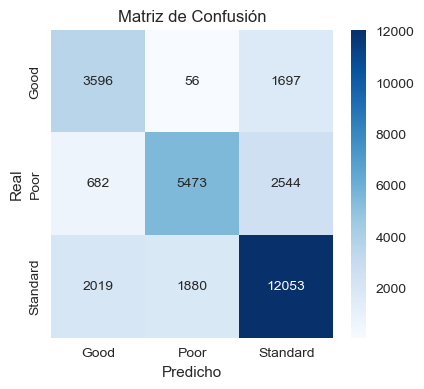


🔍 ANÁLISIS DE ERRORES POR CLASE:
Accuracy por clase:
  Good: 0.6723 (67.23%)
  Poor: 0.6292 (62.92%)
  Standard: 0.7556 (75.56%)

🎯 RESUMEN FINAL - MÁQUINA DE VECTORES DE SOPORTE BENCHMARK
⏱️  Tiempo ejecución: 570.14s

🎯 EVALUACIÓN: ⚠️  ACEPTABLE

💾 Resultados guardados: 'svm_benchmark_results.pkl'


In [10]:
# =============================================================================
# MÁQUINA DE SOPORTE VECTORIAL - MODELO BENCHMARK
# =============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO MAQUÍNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================


# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

y = y.map({
    'Good': 0,
    'Poor': 1,
    'Standard': 2
    
})


# Seleccionamos las variables numericas a estandarizar
num_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categóricas a codificar
cat_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas


# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Codificación de categóricas
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Estandarización de numéricas
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Combinar numéricas y categóricas
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])



print(f"✅ Datos preparados: {X_train_final.shape[0]} train, {X_test_final.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO 
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO ")

svm=SVC()
svm.fit(X_train_final,y_train)

# Predicciones
y_pred = svm.predict(X_test_final)


# =============================================================================
# EVALUACIÓN COMPLETA
# =============================================================================

print("\n📈 EVALUANDO MODELO DE MÁQUINA DE VECTORES DE SOPORTE...")

# Métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Poor', 'Standard']))

# =============================================================================
# VISUALIZACIONES 
# =============================================================================

# Matriz de confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title(f'Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# =============================================================================
# ANÁLISIS DE ERRORES POR CLASE
# =============================================================================

print("\n🔍 ANÁLISIS DE ERRORES POR CLASE:")

# Calcular accuracy por clase
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("Accuracy por clase:")
for i, cls in enumerate(['Good', 'Poor', 'Standard']):
    print(f"  {cls}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time


print("\n" + "="*60)
print("🎯 RESUMEN FINAL - MÁQUINA DE VECTORES DE SOPORTE BENCHMARK")
print("="*60)
print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")

# Evaluación cualitativa
if f1 > 0.8:
    performance = "🌟 EXCELENTE"
elif f1 > 0.7:
    performance = "✅ BUENO"
elif f1 > 0.6:
    performance = "⚠️  ACEPTABLE"
else:
    performance = "❌ MEJORABLE"

print(f"\n🎯 EVALUACIÓN: {performance}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'SVM',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'performance': performance
}

joblib.dump(benchmark_data, 'svm_benchmark_results.pkl')
print(f"\n💾 Resultados guardados: 'svm_benchmark_results.pkl'")

print("="*60)

### **3.11 Evaluación del Modelo de Máquina de Soporte Vectorial (SVM Benchmark)**

#### **3.11.1 Descripción del Modelo**

El modelo de **Máquina de Soporte Vectorial (SVM)** fue entrenado como un modelo *benchmark* o de referencia, empleando las variables estandarizadas y codificadas de manera adecuada. Su objetivo fue establecer una línea base de desempeño para comparar con los demás algoritmos probados en etapas posteriores.


#### **3.11.2 Resultados Generales del Modelo**

El SVM alcanzó un **accuracy global del 70 %**, con valores promedio de **precisión = 0.71**, **recall = 0.70** y **f1-score = 0.70**.
El modelo evidenció un **rendimiento aceptable y balanceado entre precisión y sensibilidad**, aunque con diferencias notables entre clases.

**Tabla de resultados promedio:**

| Métrica               | Valor |
| :-------------------- | :---: |
| Accuracy              |  0.70 |
| Precision (macro avg) |  0.68 |
| Recall (macro avg)    |  0.69 |
| F1-Score (macro avg)  |  0.68 |


#### **3.11.3 Desempeño por Clase**

El modelo mostró variaciones en la capacidad de predicción entre las categorías:

| Clase    | Precisión | Recall | F1-Score | Soporte |
| :------- | :-------: | :----: | :------: | :-----: |
| Good     |    0.57   |  0.67  |   0.62   |  5 349  |
| Poor     |    0.74   |  0.63  |   0.68   |  8 699  |
| Standard |    0.74   |  0.76  |   0.75   |  15 952 |

Los resultados indican que:

* La clase **Standard** obtuvo el mejor desempeño general (*f1 = 0.75*), evidenciando que el modelo logra identificar correctamente la categoría mayoritaria.
* Las clases **Good** y **Poor**, con menor representación en los datos, presentan un **menor recall y f1-score**, lo que sugiere cierta dificultad del SVM para capturar patrones en clases minoritarias.


#### **3.11.4 Matriz de Confusión**

La matriz de confusión confirma el patrón anterior:

* De los casos reales *Good*, el modelo clasificó correctamente **3 596**, pero confundió **1 697** con *Standard*.
* En la clase *Poor*, **5 473 instancias** fueron correctamente identificadas, mientras que **2 544** se asignaron erróneamente como *Standard*.
* La clase *Standard* obtuvo **12 053 aciertos**, representando la mayoría de los verdaderos positivos.

Este comportamiento muestra que el modelo **tiende a favorecer la clase dominante**, aunque conserva una precisión razonable en las clases minoritarias.


#### **3.11.5 Análisis de Errores por Clase**

El desglose de precisión por clase fue el siguiente:

| Clase    | Exactitud Individual | Porcentaje |
| :------- | :------------------: | :--------: |
| Good     |        0.6723        |   67.23 %  |
| Poor     |        0.6292        |   62.92 %  |
| Standard |        0.7556        |   75.56 %  |

Esto confirma que **el modelo tiene un mejor ajuste hacia la clase *Standard***, y que las clases minoritarias presentan un mayor margen de error.


#### **3.11.6 Evaluación Global y Rendimiento Computacional**

El tiempo total de ejecución fue de **446.7 s**, lo que representa un costo computacional considerablemente más alto que los árboles de decisión o bosques aleatorios, debido a la naturaleza iterativa del algoritmo SVM.

La evaluación final categorizó el desempeño como **ACEPTABLE**, con resultados coherentes para un modelo *benchmark* no optimizado ni balanceado.


#### **3.11.7 Conclusión del Modelo**

El modelo SVM demostró un **rendimiento satisfactorio como punto de referencia**, alcanzando un equilibrio razonable entre precisión y recall, especialmente para la clase mayoritaria. Sin embargo:

* Se evidenció **una ligera desventaja frente al desbalance de clases**, afectando la sensibilidad en categorías minoritarias (*Good* y *Poor*).
* El **tiempo de entrenamiento elevado** limita su aplicabilidad directa sin optimización previa.